In [65]:
# pip install geopy


## Оглавление / Table Of Content: <a class="anchor" id="100"></a>
* [0. Описание задачи / Task Description](#0)
* [1. Загрузка данных / Loading Data](#1)
* [2. Описывающие отель cтолбцы / Hotel Related Columns](#2)
* [3 Столбцы относящиеся к рецензенту / Reviewer related columns](#3)
* [4. Столбцы связанные с временем / Time-related columns](#4)
* [5. Столбцы связанные с отзывами / Review-related columns](#5)
* [6. Отбор признаков / Features selection](#6)
* [7. Построение моделей / Modelling](#7)
* [8. Заключение / Conclusion](#8)

In [66]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import preprocessing

import category_encoders as ce

import geopy.distance
from geopy.geocoders import Nominatim
from geopy import distance

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('vader_lexicon')

import time
from datetime import datetime as dt


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [67]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42


In [68]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt


# 0. Описание задачи / Task Description <a class="anchor" id="0"></a>

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель.

Imagine that you work as a data scientist at Booking company. One of the company's problems is dishonest hotels that wind up rating themselves. One of the ways to detect such hotels is to build a model that predicts the rating of the hotel. If the model's predictions are very different from the actual result, then perhaps the hotel is behaving dishonestly, and it is worth checking. You are tasked with creating such a model.

You are tasked with creating such a model.

## Описание данных / Dataset description (16)

### Связанные с отелем признаки / Hotel Related Features (7)

1. **hotel_name** - full hotel name;

2. **hotel_address** - address: street, post code, city, country;

3. **lat - hotel** latitude coordinate;

4. **lng - hotel** longitude coordinate;

5. **average_score** - average hotel rating;

6. **total_number_of_reviews** - total number of hotel reviews;

7. **additional_number_of_scoring** - number of hotel scores without review.

### Связанные с рецензентом признаки / Reviewer Related Features (3)

1. **reviewer_nationality** - reviewer nationality;

2. **total_number_of_reviews_reviewer_has_given** - total number of reviews reviewer has given;

3. **tags** - tags describing stay in the hotel.

### Связанные с отзывом признаки / Review Related Features (6)

1. **review_date** - date of review;

2. **days_since_review** - difference in the number of days between review date and scrape date;

3. **negative_review** - text of negative review;

4. **review_total_negative_word_counts** - negative review words number;

5. **positive_review** - text of positive review;

6. **review_total_positive_word_counts** - positive review words number.

[**Содержание**](#100)

# 1. Загрузка данных / Loading Data <a class="anchor" id="1"></a>

In [69]:
# подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн


In [70]:
# для корректной обработки признаков объединяем трейн и тест в один датасет

df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


/tmp/ipykernel_34/1851171259.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [71]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

[**Содержание**](#100)

# 2. Описывающие отель cтолбцы / Hotel Related Columns <a class="anchor" id="2"></a>

Имеется 7 столбцов описывающих отели:

There are 7 columns related to hotels:

- hotel_name - full hotel name;
- hotel_address - address: street, post code, city, country;
- lat - hotel latitude coordinate;
- lng - hotel longitude coordinate;
- average_score - average hotel rating;
- total_number_of_reviews - total number of hotel reviews;
- additional_number_of_scoring - number of hotel scores without review.

## 2.1 Название отеля 1/ Hotel name 1

Проверяем наличие отелей с одинаковыми названиями.

Checking if there are duplicated hotel names.

In [72]:
# список всех записей "отель - адрес"
hotel_address = data.groupby(['hotel_name', 'hotel_address'])['hotel_name'].count()

# количество адресов для каждого названия
hotel_address = hotel_address.groupby('hotel_name').count().sort_values(ascending=False)

# название и количество (для первой записи, где количество отлично от 1)
hotel_name = hotel_address.index[0]
number_duplicated = hotel_address[0]

print(str(number_duplicated) + " hotels has the same name '" + hotel_name + "'" + 'and different addresses.')


3 hotels has the same name 'Hotel Regina'and different addresses.


Переименуем эти отели, чтобы имена были уникальными - добавим одну цифру к названию.

Rename hotels with the same name - by adding one digit.

In [73]:
# выделяем все записи для отеля с найденным названием и удаляем все дубликаты
# получаем массив из трех адресов
hotels_to_rename = data[data['hotel_name'] == hotel_name]['hotel_address'].drop_duplicates().values

# для каждого такого адреса в название отеля добавляем цифру (0, 1 и 2, соответственно)
for i in range(len(hotels_to_rename)):
    data.loc[(data['hotel_address'] == hotels_to_rename[i]), 'hotel_name'] = 'Hotel Regina ' + str(i)
    print(i, ': Hotel Regina ' + str(i) + ' - ', hotels_to_rename[i])


0 : Hotel Regina 0 -  Bergara 2 4 Eixample 08002 Barcelona Spain
1 : Hotel Regina 1 -  Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria
2 : Hotel Regina 2 -  Via Cesare Correnti 13 Milan City Center 20123 Milan Italy


In [74]:
print('There are ' + str(data['hotel_name'].nunique()) + ' hotels, all with unique names.')


There are 1494 hotels, all with unique names.


[**Содержание**](#100)

## 2.2 Создание датасета с информацией по отелям / Creating dataframe containing info about hotels

Сделаем фрейм данных, содержащий информацию об отелях. Будем работать с ним при анализе информации, связанной с отелями. Это значительно меньше, чем весь набор данных.

Let's make a data frame containing information about hotels. We will work with him when analyzing information related to hotels. This is significantly smaller than the entire dataset.

In [75]:
# создадим множества всех признаков и признаков, связанных с отелями
# и вычтем второе из первого, получим список "лишних" признаков
hotel_related_columns = {'hotel_name', 'hotel_address', 'lat', 'lng', 'average_score', 'total_number_of_reviews', 'additional_number_of_scoring'}
all_columns = set(data.columns)
columns_to_delete = list(all_columns - hotel_related_columns)

# удалим "лишние" признаки
hotels = data.drop(columns_to_delete, axis = 1)

hotels


,hotel_address,additional_number_of_scoring,average_score,hotel_name,total_number_of_reviews,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,16670,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,5018,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,351,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,9.1,Hotel Principe Di Savoia,1543,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,9.1,Hotel Esther a,4687,52.370545,4.888644
...,...,...,...,...,...,...,...
515733,9 Knaresborough Place Kensington and Chelsea L...,107,9.0,Hotel Moonlight,617,51.494028,-0.191050
515734,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,8.4,BEST WESTERN PLUS Amedia Wien,3224,48.192379,16.399451
515735,29 31 Gower Street Camden London WC1E 6HG Unit...,457,6.8,Bloomsbury Palace Hotel,2751,51.520795,-0.131084
515736,31 Great Cumberland Place Westminster Borough ...,365,8.1,The Marble Arch London,1567,51.515125,-0.160066


Очевидно, что имеются дубликаты записей для каждого отеля, ведь отелей всего 1494. Удалим все такие дубликаты. Еще переименуем названия признаков для удобства и переставим название отеля на первое место.

Obviously, there are duplicate records for each hotel, because there are only 1494 hotels. Delete such duplicates, rename the names of the signs for convenience and move the name of the hotel to the first place.

In [76]:
# удалим все дубликаты по именам отелей
hotels.drop_duplicates(subset=['hotel_name'], inplace=True)

# переиндексируем
hotels.reset_index(drop=True, inplace=True)

# переставим название отеля на первое место
hotels = hotels[['hotel_name', 'hotel_address', 'additional_number_of_scoring', 'average_score', 'total_number_of_reviews', 'lat', 'lng']]

# переименуем все столбцы
hotels.columns = ['name', 'address', 'no_review_scores', 'score', 'reviews', 'lat', 'lng']

hotels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1494 non-null   object 
 1   address           1494 non-null   object 
 2   no_review_scores  1494 non-null   int64  
 3   score             1494 non-null   float64
 4   reviews           1494 non-null   int64  
 5   lat               1477 non-null   float64
 6   lng               1477 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 81.8+ KB


Датасет hotels стал намного меньше data - всего 82 KB вместо 71 MB.

The hotels dataset has become much smaller than data - only 82 KB instead of 71 MB.

[**Содержание**](#100)

## 2.3 Сети отелей - Классы отелей / Hotel Chains - Hotel classes

Некоторые отели входят в сети (цепочки брендов), а так же имеют определенный класс. Из открытых источников (Википедия) взята информация об  отельных сетях, владеющих брендами с объектами в Западной Европе. Составлен словарь из 4 элементов, где ключ - класс отеля (Luxury, Premium, Midscale, Economy) и значение - перечень брендов отельных сетей, имеющих данный класс. Заранее можно отметить, что отельным сетям принадлежит примерно пятая часть рынка. Соответственно, только такая часть отелей из датаста сможет получить этот новый признак "класс сетевого отеля" (для краткости названный level).

Some hotels are part of chains (chains of brands), and also have a certain class. Information about hotel chains owning brands with facilities in Western Europe is taken from open sources (Wikipedia). A dictionary of 4 elements has been compiled, where the key is the class of the hotel (Luxury, Premium, Midscale, Economy) and the value is a list of brands of hotel chains that have this class. It can be noted in advance that hotel chains own about a fifth of the market. Accordingly, only such a part of the hotels from the datast will be able to get this new feature "network hotel class" (called level for short).

In [77]:
# словарь с 4 классами и списками брендов для каждого класса
hotel_level = {
    'Luxury': ['Banyan Tree', 'Delano', 'Fairmont', 'onefinestay', 'Orient Express', 'Raffles',
               'Rixos', 'SLS', 'SO/', 'Sofitel', 'Sofitel Legend', 'The House of Originals',
               'Best Western Premier', 'BW Premier Collection', 'Sadie', 'Vib', 'Conrad', 'LXR',
               'Waldorf Astoria', 'Intercontinental Hotels & Resorts', 'Kimpton Hotels & Restaurants',
               'Regent Hotels & Resorts', 'Six Senses Hotels & Resorts', 'Edition', 'JW Marriott',
               'The Luxury Collection', 'The Ritz-Carlton', 'St. Regis', 'W Hotels', 'Radisson Collection',
               'Wyndham Grand', 'Ascott The Residence', 'Banyan Tree', 'Le Fouquets Paris', 'Le Majestic Cannes',
               'Les Neiges Courchevel', 'Le Normandy Deauville', 'Dorchester Collection', 'Four Seasons Hotels',
               'Chedi Hotels', 'Park Hyatt', 'Grand Hyatt', 'Kempinski', 'Langham Hotels', 'Langham Place Hotels',
               'Mandarin Oriental', 'Gran Melia', 'ME by Melia', 'Paradisus', 'Anantara', 'Per Aquum',
               'Rosewood Hotels & Resorts', 'Shangri-La Hotels'],

    'Premium': ['25 Hours', 'Angsana', 'Art Series', 'Grand Mercure', 'Hyde', 'Mantis', 'MGallery X 21C',
                'Mondrian', 'M venpick', 'Peppers', 'Pullman', 'Swissôtel', 'The Sebel', 'Ascend Collection',
                'Cambria Suites', 'Clarion Hotel', 'Canopy', 'Curio Collection', 'DoubleTree', 'Embassy Suites',
                'Hilton', 'Signia', 'Tapestry Collection', 'Alila Andaz', 'Exhale Spa & Fitness', 'Grand Hyatt',
                'Hyatt', 'Miraval', 'Park Hyatt', 'The Unbound Collection', 'Thompson Hotels',
                'Crowne Plaza Hotels & Resorts', 'Even Hotels', 'Hotel Indigo', 'Hualuxe Hotels & Resorts',
                'Voco', 'Autograph Collection', 'Delta', 'Design Hotels', 'Gaylord Hotels', 'Le Meridien',
                'Marriott', 'Marriott Vacation Club', 'Renaissance', 'Sheraton', 'Tribute Portfolio',
                'Westin Hotels & Resorts', 'Park Plaza', 'Radisson', 'Radisson Blu', 'Radisson Red',
                'Dolce Hotels and Resorts', 'Wyndham', 'Cassia', 'Angsana', 'Hyatt Regency', 'Hyatt Hotels',
                'Andaz', 'Hyatt Place', 'Hyatt House Hotels', 'Hyatt Centric', 'Cordis Hotels', 'Melia',
                'Innside', 'Grand Millenium Hotels', 'Millennium Hotels' 'Grand Copthrone Hotels', 'Tivoli',
                'Elewana', 'NHow', 'NH Collection', 'Hesperia Resorts', 'OYO Hotel & Casino', 'OYO Vacation Homes',
                'New World Hotels', 'Pentahotels', 'KHOS', 'Kerry Hotels', 'Traders Hotels', 'Hotel Jen',
                'Wyndham Grand', 'Dolce', 'Wyndham'],

    'Midscale': ['Adagio', 'Mama Shelter', 'Mantra', 'Mercure', 'Novotel', 'Tribe', 'Aiden', 'Best Western',
                 'Best Western Plus', 'Executive Residency', 'GLo', 'BW Signature Collection', 'SureStay',
                 'SureStay Collection', 'SureStay Plus', 'Clarion Inn', 'Comfort Inn', 'Comfort Suites',
                 'MainStay Suites', 'Sleep Inn', 'Quality Inn', 'Hampton', 'Hampton Inn', 'Hilton Garden Inn',
                 'Hilton Grand Vacations', 'Homewood Suites', 'Home2 Suites', 'Motto', 'Tru', 'Caption',
                 'Destination Hotels', 'Hyatt Centric', 'Hyatt House', 'Hyatt Place', 'Hyatt Regency',
                 'Hyatt Residence Club', 'Hyatt Zilara', 'Hyatt Ziva', 'Joie de Vivre', 'Atwell Suites',
                 'Avid', 'Candlewood Suites', 'Holiday Inn', 'Holiday Inn Club Vacations', 'Holiday Inn Express',
                 'Holiday Inn Resort', 'Staybridge Suites', 'AC Hotels', 'Aloft Hotels', 'Courtyard',
                 'Fairfield Inn & Suites', 'Four Points', 'Moxy Hotels', 'Protea Hotels', 'SpringHill Suites',
                 'Element', 'Homes & Villas', 'Marriott Executive Apartments', 'Residence Inn', 'TownePlace Suites',
                 'Country Inn & Suites', 'Park Inn', 'Esplendor Boutique Hotels', 'Dazzler', 'Trademark Collection',
                 'TRYP', 'AmericInn', 'Baymont Inn & Suites', 'La Quinta Inns & Suites', 'Ramada', 'Ramada Encore',
                 'Wingate', 'Wyndham Garden', 'Citadines Aparthotel', 'Somerset Serviced Residence',
                 'Quest Apartment Hotels', 'lyf', 'Dhawa', 'Eaton Hotels', 'Chelsea Hotels', 'Magnuson Grand',
                 'Magnuson Hotels', 'Sol', 'Copthorne Hotels', 'M Hotels', 'Kingsgate Hotels', 'Oaks Hotels & Resorts',
                 'NH Hoteles', 'OYO Townhouse', 'Capital O', 'Collection OOYO Home', 'Palette Resort', 'Premier Inn',
                 'TRYPE', 'Esplendor', 'Dazzler', 'Trademark', 'La Quinta', 'Wingate', 'Wyndham Garden', 'AmericInn',
                 'Ramada', 'Baymont'],

    'Economy': ['Breakfree', 'Greet', 'hotelF1', 'Ibis', 'Jo&Joe', 'Econo Lodge', 'Rodeway Inn', 'Suburban',
                'Woodspring Suites', 'Days Inn', 'Howard Johnson', 'Microtel Inn & Suites', 'Super 8', 'Travelodge',
                'M-Star Hotels', 'OYO Rooms', 'hub by Premier Inn', 'Microtel', 'Days Inn', 'Howard Johnsons']
}

# функция проверяет присутствует ли в названии отеля название бренда из словаря
# (одного из 4 списков - значений ключей словаря), # если да -
# возвращает класс отеля (соответствующий ключ словаря), если нет - 'Undefined'
def get_hotel_chain(hotel_name):
    """ Checking whether the hotel belongs to one of the 4 classes by name.

    Args:
        hotel_name (str): hotels'name

    Returns:
        (str): One of the 4 hotel classes or 'Undefined'
    """
    for level in hotel_level.keys():
        for brand in hotel_level[level]:
            if hotel_name.lower().find(brand.lower()) != -1:
                return level
    return 'Undefined'

# создадим новый признак level - "класс сетевого отеля"
hotels['level'] = hotels['name'].apply(get_hotel_chain)

# выведем процентное соотношение классов сетевых отелей и
# процент неопределенных отелей
df = pd.DataFrame(hotels['level'].value_counts(normalize=True)*100).apply(lambda x: round(x, 4)).reset_index(drop=False)

df = df.rename(columns={"index": "level", "level": "proportion"})

df


/tmp/ipykernel_34/2729877085.py:75: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,level,proportion
0,Undefined,75.6359
1,Premium,10.8434
2,Midscale,10.5087
3,Luxury,2.8782
4,Economy,0.1339


In [ ]:
fig = go.Figure(go.Pie(labels=df['level'], values=df['proportion']))

fig.update_layout(height=700, width=700, title="Percentage distribution of hotel classes", title_x = 0.5)

fig.show()


В результате 75.64 % отелей не являются сетевыми (т.н. независимые) и их не удалось классифицировать с помощью словаря. Но определение класса для четверти отелей - даже лучше ожидаемого. Можно предположить, что отели Undefined скорее всего имеют класс Economy и  Midscale. На амом деле здесь смесь двух признаков: сетевой отель или независимый и класс отеля. Можно их разделить. Признак класса уже есть (с долей неопределенных). Введем признак сетевого отеля chain - все Undefined это не сетевые отели, остальные,соответственно, сетевые.

As a result, 75.64% of hotels are not chain hotels (so-called independent) and they could not be classified using a dictionary. But the definition of class for a quarter of hotels is even better than expected. It can be assumed that Undefined hotels most likely have Economy and Midscale class. In fact, there is a mixture of two features: a chain hotel or an independent and a hotel class. You can separate them. The class attribute already exists (with a fraction of undefined). Let's introduce the chain hotel attribute - all Undefined are not chain hotels, the rest, respectively, are network hotels.

In [79]:
# 1 - сетевой отель, 0 - НЕ сетевой
hotels['chain'] = hotels['level'].apply(lambda x: 0 if x == 'Undefined' else 1)


/tmp/ipykernel_34/3244111844.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[**Содержание**](#100)

## 2.4 Адрес отеля / Hotel address

In [80]:
hotels['address'].value_counts().count()


1493

В датасете 1493 адреса и 1494 отеля. Это означает, что два отеля имеют один и тот же адрес. В этом нет какой-либо проблемы.

There are 1493 addresses and 1494 hotels in the dataset. This means that two hotels have the same address. There is no problem with that.

Адрес отеля это последовательность: улица (площадь, район и т.п.), номер здания, почтовый код, город и страна. Страна - это последнее слово адреса, в случае Соединенного Королевства - последние два слова. Город - это второе слово с конца, в случае Соединенного Королевства - пятое слово с конца (еще два слова - почтовый код). Соответственно, сконструируем два новых признака city и country.

The address of the hotel is a sequence: street (square, district, etc.), building number, postal code, city and country. The country is the last word of the address, in the case of the United Kingdom, the last two words. City is the second word from the end, in the case of the United Kingdom - the fifth word from the end (two more words are the postal code). Accordingly, we will construct two new signs city and country.

In [81]:
# признак страны для отелей
hotels['country'] = hotels['address'].apply(lambda x: " ".join(x.split()[-2:]) if x.split()[-1] == 'Kingdom' else x.split()[-1])

print('There are hotels from ' + str(hotels['country'].nunique()) + ' different countries.\n')
print(hotels['country'].value_counts())

# признак города для отелей
hotels['city'] = hotels['address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

print('\nThere are hotels from ' + str(hotels['country'].nunique()) + ' different countries.\n')
print(hotels['country'].value_counts())


There are hotels from 6 different countries.

France            458
United Kingdom    400
Spain             211
Italy             162
Austria           158
Netherlands       105
Name: country, dtype: int64

There are hotels from 6 different countries.

France            458
United Kingdom    400
Spain             211
Italy             162
Austria           158
Netherlands       105
Name: country, dtype: int64


/tmp/ipykernel_34/300927977.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_34/300927977.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df = pd.DataFrame(hotels['country'].value_counts(normalize=True)).reset_index()

df = df.rename(columns={"index": "country", "country": "proportion"})

fig = go.Figure(go.Pie(labels=df['country'], values=df['proportion']))

fig.update_layout(height=700, width=700, title="Percentage distribution of hotels by country", title_x = 0.5)

fig.show()


Очевидно, что эти два новых признака полностью дублируют друг друга. Каждый отель расположен в одной из шести стран: France, United Kingdom, Spain, Italy, Austria, Netherlands. И в одном из шести городов: Paris, London, Barcelona, Milan, Vienna, Amsterdam (столица страны или один из крупнейших городов).

The address of the hotel is a sequence: street (square, district, etc.), building number, postal code, city and country. The country is the last word of the address, in the case of the United Kingdom, the last two words. City is the second word from the end, in the case of the United Kingdom - the fifth word from the end (two more words are the postal code). Accordingly, we will construct two new signs city and country.

[**Содержание**](#100)

## 2.5 Координаты / Coordinates

In [83]:
hotels_miss_coordinates = hotels[['name', 'address', 'lat', 'lng']][hotels['lat'].isnull() | hotels['lng'].isnull()].reset_index(drop=True)

hotels_miss_coordinates


,name,address,lat,lng
0,Hotel Atlanta,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,NaN,NaN
1,City Hotel Deutschmeister,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,NaN,NaN
2,Holiday Inn Paris Montmartre,23 Rue Damr mont 18th arr 75018 Paris France,NaN,NaN
3,Fleming s Selection Hotel Wien City,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,NaN,NaN
4,Hotel City Central,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,NaN,NaN
5,Cordial Theaterhotel Wien,Josefst dter Stra e 22 08 Josefstadt 1080 Vien...,NaN,NaN
6,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,NaN,NaN
7,Hotel Daniel Vienna,Landstra er G rtel 5 03 Landstra e 1030 Vienna...,NaN,NaN
8,Maison Albar Hotel Paris Op ra Diamond,4 rue de la P pini re 8th arr 75008 Paris France,NaN,NaN
9,Mercure Paris Gare Montparnasse,20 Rue De La Ga t 14th arr 75014 Paris France,NaN,NaN


Есть 17 отелей с отсутствующими координатами (парами). Получим пропущенные координаты с помощью геокодера Nominatim (применяя его к названиям отелей + название города и страны - на всякий случай).

There are 17 hotels with missing coordinates (pairs). We will get the missing coordinates using the Nominatim geocoder (applying it to the names of hotels + name of the city and country - just in case).

In [84]:
geolocator = Nominatim(user_agent="kaggle_learn")

for i in hotels_miss_coordinates['name']:
    name_address = i + ' ' + ' '.join(hotels_miss_coordinates[hotels_miss_coordinates['name'] == i]['address'].values[0].split()[-2:])
    location = geolocator.geocode(name_address)
    if location:
        hotels.loc[hotels['name'] == i, ['lat']] = location.latitude
        hotels.loc[hotels['name'] == i, ['lng']] = location.longitude
        hotels.loc[hotels['name'] == i, ['address']] = location.address
    else:
        print('failure for ', i, '\n')


failure for  City Hotel Deutschmeister 

failure for  Fleming s Selection Hotel Wien City 

failure for  Hotel Daniel Vienna 

failure for  Maison Albar Hotel Paris Op ra Diamond 

failure for  Mercure Paris Gare Montparnasse 

failure for  Hotel Pension Baron am Schottentor 

failure for  Derag Livinghotel Kaiser Franz Joseph Vienna 

failure for  Hotel Advance 



Для 8 отелей геокодер Nominatim не может обработать название с городом/страной нахождения. Сделаем словарь correct_hotel_addresses с адресами этих отелей вручную (информация из интернета) и проверим, что используя адреса из этого словаря геокодер нормально обрабатывает запрос. Причем словарь будет для 10 отелей, т.к. еще для двух отелей присутствует ошибка в координатах. 

For 8 hotels, the Nominatim geocoder cannot process the name with the city/country of location. We will make a dictionary with the addresses of these hotels manually (information from the Internet) and check that using the addresses from this dictionary, the geocoder processes the request normally. Moreover, the dictionary will be for 10 hotels, because there is an error in coordinates for two more hotels.

In [85]:
correct_hotel_addresses = {
    'City Hotel Deutschmeister': 'Grünentorgasse 30 09 Alsergrund 1090 Vienna',
    'Fleming s Selection Hotel Wien City': 'Josefstädter Straße 10-12 1080 Vienna Austria',
    'Hotel Pension Baron am Schottentor': 'Währinger Straße 12 1090 Vienna Austria',
    'Derag Livinghotel Kaiser Franz Joseph Vienna': 'Sieveringer Straße 4 1190 Vienna Austria',
    'Maison Albar Hotel Paris Op ra Diamond': '4 rue de la Pépinière 75008 Paris France',
    'Mercure Paris Gare Montparnasse': '75014 Paris France',
    'Hotel Atlanta': 'Währinger Straße 33 A-1090 Vienna Austria',
    'Hotel Park Villa': 'Hasenauerstraße 12 1190 Vienna Austria',
    'Hotel Advance': 'Sepúlveda 180 Barcelona Spain',
    'Hotel Daniel Vienna': 'Landstraßer Gürtel 5 1030 Vienna Austria'
}

for i in correct_hotel_addresses.items():
    location = geolocator.geocode(i[1])
    print(round(location.latitude, 6), round(location.longitude, 6), i[0], )


48.221157 16.362029 City Hotel Deutschmeister
48.209834 16.347562 Fleming s Selection Hotel Wien City
48.216813 16.359936 Hotel Pension Baron am Schottentor
48.245964 16.341224 Derag Livinghotel Kaiser Franz Joseph Vienna
48.875248 2.323375 Maison Albar Hotel Paris Op ra Diamond
48.830891 2.324767 Mercure Paris Gare Montparnasse
48.220301 16.355883 Hotel Atlanta
48.233523 16.345655 Hotel Park Villa
41.383234 2.16294 Hotel Advance
48.188863 16.383852 Hotel Daniel Vienna


Видно, что с этими данными геокодер выдает правильные результаты. Теперь заполним недостающие координаты в датасете.

It can be seen that with this data, the geocoder gives the correct results. Now fill in the missing coordinates in the dataset.

In [86]:
for i in correct_hotel_addresses.items():
    location = geolocator.geocode(i[1])
    hotels.loc[hotels['name'] == i[0], ['lat']] = location.latitude
    hotels.loc[hotels['name'] == i[0], ['lng']] = location.longitude
    hotels.loc[hotels['name'] == i[0], ['address']] = location.address


In [87]:
# проверим на наличие пропусков
print(hotels.isnull().sum())


name                0
address             0
no_review_scores    0
score               0
reviews             0
lat                 0
lng                 0
level               0
chain               0
country             0
city                0
dtype: int64


Все нормально.

Everything is fine.

In [88]:
#  проверим на количество уникальных значений (дубликаты)
duplicats = hotels[hotels.duplicated(['lat', 'lng'], keep = False)].sort_values(by=['lat', 'lng'])

duplicats


,name,address,no_review_scores,score,reviews,lat,lng,level,chain,country,city
392,Hotel Auriga,Via G B Pirelli 7 Central Station 20124 Milan ...,113,8.2,1299,45.485888,9.204283,Undefined,0,Italy,Milan
690,Best Western Hotel City,Corso Buenos Aires 42 5 Central Station 20124 ...,84,8.4,1193,45.485888,9.204283,Midscale,1,Italy,Milan
217,Hotel VIU Milan,6 Via Aristotile Fioravanti Garibaldi Station ...,30,8.9,219,45.488764,9.183057,Undefined,0,Italy,Milan
1350,Holiday Inn Milan Garibaldi Station,Via Ugo Bassi 1 A Ang Via C Farini Garibaldi S...,45,8.3,484,45.488764,9.183057,Midscale,1,Italy,Milan
245,Rubens At The Palace,39 Buckingham Palace Road Westminster Borough ...,332,8.7,1449,51.498147,-0.143649,Undefined,0,United Kingdom,London
1358,41,41 Buckingham Palace Road Westminster Borough ...,66,9.6,244,51.498147,-0.143649,Undefined,0,United Kingdom,London
251,Club Quarters Hotel Trafalgar Square,8 Northumberland Avenue Westminster Borough Lo...,602,8.5,2494,51.506935,-0.126012,Undefined,0,United Kingdom,London
529,The Grand at Trafalgar Square,8 Northumberland Avenue Westminster Borough Lo...,409,8.3,1592,51.506935,-0.126012,Undefined,0,United Kingdom,London
165,Lancaster London,Lancaster Terrace Westminster Borough London W...,365,8.3,1463,51.511945,-0.179939,Undefined,0,United Kingdom,London
220,Corus Hotel Hyde Park,Lancaster Gate Westminster Borough London W2 3...,452,7.6,2562,51.511945,-0.179939,Premium,1,United Kingdom,London


Очевидно, что присутствуют пять дубликатов по координатам. Попробуем для этих адресов и названий отелей получить координаты с помощью геокодера Nominatim.

Obviously, there are five duplicates by coordinates. Let's try to get coordinates for these addresses and hotel names using the Nominatim geocoder.

In [89]:
for i in duplicats['name']:
    name_address = i + ' ' + ' '.join(duplicats[duplicats['name'] == i]['address'].values[0].split()[-2:])
    location = geolocator.geocode(name_address)
    if location:
        hotels.loc[hotels['name'] == i, ['lat']] = location.latitude
        hotels.loc[hotels['name'] == i, ['lng']] = location.longitude
        hotels.loc[hotels['name'] == i, ['address']] = location.address
    else:
        print('failure for ', i, '\n')


failure for  Holiday Inn Milan Garibaldi Station 

failure for  Club Quarters Hotel Trafalgar Square 



Не удалось проверить и найти адреса и координаты двух отелей. Проверка вручную показала, что адреса указаны верные, координаты тоже.

It was not possible to check and find the addresses and coordinates of two hotels. A manual check showed that the addresses are correct, the coordinates are also correct.

[**Содержание**](#100)

## 2.6 Расстояние до центра города и другие городские признаки / Distance to the city center and other city signs

Подготовим словарь с рядом географических параметров всех шести городов.

We will prepare a dictionary with a number of geographical parameters of all six cities.

* координаты центра / center coordinates;
* население в миллионах / population in million;
* площадь/ area in km2;
* условный радиус / radius in km.

In [90]:
# Для каждого города: [center_lat, center_lng, population, area in km2, radius in km]
cities_info = {
    'Paris'    : [48.853410, 2.348800, 2.15, 105.4, 6.0],
    'London'   : [51.508530, -0.125740, 8.96, 1602, 22.6],
    'Barcelona': [41.388790, 2.158990, 1.64 , 101.3, 8.0],
    'Milan'    : [45.464270, 9.189510, 1.38, 181.8, 7.6],
    'Vienna'   : [48.208490, 16.372080, 1.9, 414.8, 11.5],
    'Amsterdam': [52.374030, 4.889690, 0.87, 243.7, 8.8],
}


Создадим новый столбец - расстояние от отеля до центра города с помощью геокодера

Create a new column - the distance from the hotel to the city center.

In [91]:
# определяем геодезическую дистанцию между двумя точками по их координатам
def distance_to_center(city, lat, lng):
    return round(geopy.distance.geodesic((
        cities_info[city][0], cities_info[city][1]), (lat, lng)).km, 3)

# признак расстояния от центра города
hotels['distance'] = hotels.apply(lambda x:
                                  distance_to_center(x.city, x.lat, x.lng),
                                  axis = 1)


/tmp/ipykernel_34/915701439.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Создадим новый признак - плотность населенения города density в тыс. чел. / км2.

Let's create a new feature - the population density of the city density in thousand people / km2.

In [92]:
hotels['density'] = hotels.apply(lambda x:
                                cities_info[x.city][2]/cities_info[x.city][3]*1000,
                                axis = 1)


/tmp/ipykernel_34/2705021809.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Создадим еще один признак ratio, как отношение расстояния от отеля до центра к условному радиусу города.

Let's create another attribute ratio, as the ratio of the distance from the hotel to the center to the conditional radius of the city.

In [93]:
hotels['ratio'] = hotels.apply(
    lambda x: round(x.distance/cities_info[x.city][4], 3), axis = 1)


/tmp/ipykernel_34/690635641.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Построим распределение признака ratio по каждому городу.

Let's build the distribution of the ratio attribute for each city.

In [ ]:
fig = make_subplots(
    rows=3,
    cols=2,
    horizontal_spacing = 0.15,
    vertical_spacing = 0.2,
    subplot_titles=('Milan', 'Barcelona', 'Paris',
                    'London', 'Vienna', 'Amsterdam'))

fig.add_trace(go.Histogram(
    x=hotels[hotels['city'] == 'Milan']['ratio'],
    nbinsx=50, name=''), 1, 1)

fig.add_trace(go.Histogram(
    x=hotels[hotels['city'] == 'Barcelona']['ratio'],
    nbinsx=50, name=''), 1, 2)

fig.add_trace(go.Histogram(
    x=hotels[hotels['city'] == 'Paris']['ratio'],
    nbinsx=50, name=''), 2, 1)

fig.add_trace(go.Histogram(
    x=hotels[hotels['city'] == 'London']['ratio'],
    nbinsx=50, name=''), 2, 2)

fig.add_trace(go.Histogram(
    x=hotels[hotels['city'] == 'Vienna']['ratio'],
    nbinsx=50, name=''), 3, 1)

fig.add_trace(go.Histogram(
    x=hotels[hotels['city'] == 'Amsterdam']['ratio'],
    nbinsx=50, name=''), 3, 2)

fig.update_layout(height=900, width=1000,
                  title="Distribution of ratio in cities",
                  title_x = 0.5,
                  bargap=0.1,
                  showlegend=False)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Distance to center / city radius ratio',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Number of hotels',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


Распределение по всем городам адекватное, кроме выброса в Лондоне. Проверм, что это.

The distribution in all cities is adequate, except for the emission in London. Let's check what it is.

In [95]:
# Выведем три самых больших ratio
hotels.sort_values('ratio', ascending=False).head(3)


,name,address,no_review_scores,score,reviews,lat,lng,level,chain,country,city,distance,density,ratio
1358,41,"VC41 Glamorgan, Bridgend, Cymru / Wales, Unite...",66,9.6,244,51.594518,-3.524364,Undefined,0,United Kingdom,London,235.909,5.593009,10.438
643,Hotel Silver,Via Riccardo Lombardi 9 11 20153 Milan Italy,18,8.4,213,45.458973,9.068751,Undefined,0,Italy,Milan,9.463,7.590759,1.245
382,Molitor Paris MGallery by Sofitel,2 avenue la Porte Molitor 16th arr 75016 Paris...,29,8.8,659,48.844890,2.252833,Luxury,1,France,Paris,7.107,20.398482,1.185


Вот один отель, у которого адрес (координаты) в 240 км от Лондона. Название отеля 41. Попробуем найти его координаты и адрес с помощью геокодера. И заменим эти данные в датасете.

Here is one hotel that has an address (coordinates) 240 km from London. The name of the hotel 41. Let's try to find its coordinates and address using a geocoder. And replace this data in the dataset.

In [96]:
location = geolocator.geocode('41 hotel')
hotels.loc[hotels['name'] == '41', ['lat']] = location.latitude
hotels.loc[hotels['name'] == '41', ['lng']] = location.longitude
hotels.loc[hotels['name'] == '41', ['address']] = location.address

mask = hotels['name'] == '41'

hotels.loc[mask, ['distance']] = distance_to_center(
    hotels[mask]['city'].values[0],
    location.latitude,
    location.longitude)

hotels.loc[mask, ['ratio']] = round(hotels[mask]['distance'].values[0]/cities_info[hotels[mask]['city'].values[0]][4], 3)

hotels[hotels['name'] == '41']


,name,address,no_review_scores,score,reviews,lat,lng,level,chain,country,city,distance,density,ratio
1358,41,"41 Hotel, 41, Buckingham Palace Road, Victoria...",66,9.6,244,51.498096,-0.143267,Undefined,0,United Kingdom,London,1.682,5.593009,0.074


Проверим распределение ratio в Лондоне.

Let's check the ratio distribution in London.

In [ ]:
fig = go.Figure(go.Histogram(
    x=hotels[hotels['city'] == 'London']['ratio'],
    nbinsx=50, name=''))

fig.update_layout(height=500, width=700,
                  title="Distribution of ratio in London",
                  title_x = 0.5,
                  bargap=0.1)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Distance to center / city radius ratio',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Number of hotels',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


Теперь все в порядке.

It's all right now.

Также очевидно, что все в порядке с признаком distance - расстоянием от отеля до центра города, т.к. он не превышает условного радиуса города для подавляющего большинстава отелей и достигает максимум 1.2 условного радиуса. 

It is also obvious that everything is fine with the distance sign - the distance from the hotel to the city center, since it does not exceed the conditional radius of the city for the vast majority of hotels and reaches a maximum of 1.2 conditional radius.

Относительно признака плотности населения density тоже все нормально. Это просто определенная константа для каждого города.

Regarding the sign of population density, density is also fine. It's just a certain constant for each city.

[**Содержание**](#100)

## 2.7 Количество отзывов / Number of reviews

Посмотрим на статистику и распределение этого признака.

Let's look at the statistics and distribution of this feature.

In [98]:
hotels.reviews.describe()


count     1494.000000
mean      1297.222222
std       1371.420726
min         43.000000
25%        422.000000
50%        867.000000
75%       1670.250000
max      16670.000000
Name: reviews, dtype: float64

In [ ]:
fig = go.Figure(go.Histogram(x=np.log(hotels['reviews'] + 1), nbinsx=50, name=''))

fig.update_layout(height=500, width=700,
                  title="Distribution of reviews number",
                  title_x = 0.5,
                  bargap=0.1
                 )

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Number of reviews - Log scale',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Count',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


Можно считать данное распределение логнормальным. Оставим данный признак.

We can consider this distribution to be lognormal. Let's leave this feature.Средний балл отеля / Hotel score

[**Содержание**](#100)

## 2.8 Средний балл отеля / Hotel score

Посмотрим на статистику и распределение этого признака.

Let's look at the statistics and distribution of this feature.

In [100]:
hotels.score.describe()


count    1494.000000
mean        8.467135
std         0.548050
min         5.200000
25%         8.100000
50%         8.500000
75%         8.900000
max         9.800000
Name: score, dtype: float64

In [ ]:
fig = go.Figure(go.Histogram(x=hotels['score'], nbinsx=50, name=''))

fig.update_layout(height=500, width=700,
                  title="Distribution of scores",
                  title_x = 0.5,
                  bargap=0.1
                 )

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Score',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Count',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


Можно считать данное распределение нормальным (с некоторыми выбросами). Оставим данный признак.

We can consider this distribution to be normal (with some outliers). Let's leave this feature.Средний балл отеля / Hotel score

Постороим график зависимости среднего балла отеля score от отношения расстояния от отеля до центра к среднему радиусу города ratio. Для наглядности немного сузим диапазон по оси среднего балла score.

Let's plot the dependence of the average score of the score hotel on the ratio of the distance from the hotel to the center to the average radius of the city ratio. For clarity, we will narrow the range a little along the axis of the average score score.

In [ ]:
cities = ['Paris', 'London', 'Barcelona', 'Milan', 'Vienna', 'Amsterdam']
color = ["orange", "red", "green", "blue", "purple", "brown"]

fig = go.Figure()

for i in range(len(cities)):
    x = hotels[hotels['city'] == cities[i]]['ratio']
    y = hotels[hotels['city'] == cities[i]]['score']

    fig.add_trace(go.Scatter(x=x,
                             y=y,
                             mode='markers',
                             name=cities[i],
                             marker_color=color[i]))

    help_fig = px.scatter(x=x, y=y, trendline='ols')
    x_trend = help_fig["data"][1]['x']
    y_trend = help_fig["data"][1]['y']

    fig.add_trace(go.Scatter(x=x_trend,
                             y=y_trend,
                             name=cities[i],
                             marker_color=color[i]))

fig.update_layout(height=700, width=1000,
                  title="Scatterplot of Score vs. Ratio",
                  title_x = 0.5,
                  yaxis_range=[7.5, 9.5])

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Ratio',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Score',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


Общее правило таково, что чем ближе отель находится к центру, тем выше его рейтинг. Меньше всего это заметно в Париже и больше всего в Барселоне.

The general rule is that the closer the hotel is to the center, the higher its rating. This is least noticeable in Paris and most of all in Barcelona.

[**Содержание**](#100)

## 2.9 Количество оценок без отзыва / Number of scores w/o review

Посмотрим на статистику и распределение этого признака.

Let's look at the statistics and distribution of this feature.

In [103]:
hotels.no_review_scores.describe()


count    1494.000000
mean      190.715529
std       245.254967
min         1.000000
25%        53.000000
50%       106.000000
75%       231.000000
max      2682.000000
Name: no_review_scores, dtype: float64

In [ ]:
fig = go.Figure(go.Histogram(x=np.log(hotels['no_review_scores'] + 1), nbinsx=50, name=''))

fig.update_layout(height=500, width=700,
                  title='Distribution of numbers of scores without reviews',
                  title_x = 0.5,
                  bargap=0.1
                 )

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Scores w/o review - Log scale',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Count',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


Можно считать данное распределение нормальным (с некоторыми выбросами). Оставим данный признак.

We can consider this distribution to be lognormal (with some outliers). Let's leave this feature.Средний балл отеля / Hotel score

[**Содержание**](#100)

## 2.10 Удаление "лишних" признаков / Removing "unnecessary" features

Теперь удалим признаки координат lat и lng. Они не несут никакой смысловой нагрузки. Признак отношения расстояния отеля от центра к условному радиусу ratio останется и будет характеризовать к чему ближе, к центру или границе города, расположен отель. То есть, этот признак безразмерный относительно города - расстояние до центра может сильно отличаться для двух отелей в разных городах, а это отношение будет одинаковым, значит отели одинаково расположены в смысле удаленности от центра и близости к окраине. Признак расстояния отеля от центра города distance тоже останется, как в чистом виде расстояние от отеля до центра города.

Now let's remove the signs of the lat and lng coordinates. They do not carry any semantic load. The sign of the ratio of the distance of the hotel from the center to the conditional radius ratio will remain and will characterize what is closer, to the center or the border of the city, the hotel is located. That is, this feature is dimensionless relative to the city - the distance to the center may be very different for two hotels in different cities, and this ratio will be the same, so the hotels are equally located in terms of distance from the center and proximity to the outskirts. The sign of the distance of the hotel from the city center distance will also remain, as in its pure form the distance from the hotel to the city center.

In [105]:
hotels.drop(['lat', 'lng'], axis = 1, inplace=True)


/tmp/ipykernel_34/2869668489.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Также удалим признак city, он совпадает с признаком country (всего шесть уникальных пар страна - город). Уникальной характеристикой города останется признак density.

In [106]:
hotels.drop(['city'], axis = 1, inplace=True)


/tmp/ipykernel_34/2154761488.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 2.11 Объединение фреймов hotels и data / Merging data and hotels datasets

In [107]:
# переименуем названия столбцов, так,
# как они называются в основном датасете
hotels = hotels.rename(columns={
    'name'            : 'hotel_name',
    'address'         : 'hotel_address',
    'score'           : 'average_score',
    'reviews'         : 'total_number_of_reviews',
    'no_review_scores': 'additional_number_of_scoring'})

hotels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   hotel_name                    1494 non-null   object 
 1   hotel_address                 1494 non-null   object 
 2   additional_number_of_scoring  1494 non-null   int64  
 3   average_score                 1494 non-null   float64
 4   total_number_of_reviews       1494 non-null   int64  
 5   level                         1494 non-null   object 
 6   chain                         1494 non-null   int64  
 7   country                       1494 non-null   object 
 8   distance                      1494 non-null   float64
 9   density                       1494 non-null   float64
 10  ratio                         1494 non-null   float64
dtypes: float64(4), int64(3), object(4)
memory usage: 128.5+ KB


In [108]:
# удалим столбцы, которые мы получим из
# датасета про отели

data_drop_list = [
    'hotel_address',
    'average_score',
    'total_number_of_reviews',
    'lat', 'lng', 'additional_number_of_scoring'
]

data = data.drop(data_drop_list, axis = 1)


In [109]:
data = data.merge(hotels, on='hotel_name', how='left')

data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   review_date                                 515738 non-null  object 
 1   hotel_name                                  515738 non-null  object 
 2   reviewer_nationality                        515738 non-null  object 
 3   negative_review                             515738 non-null  object 
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   positive_review                             515738 non-null  object 
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   tags                                        515738 non-null  object 
 9   days_since_review                           515738 non-null  object 
 

[**Содержание**](#100)

## 2.12 Связь оценки с уровнем отеля по странам (без учета НЕсетевых отелей) / Relationship of score with the hotel level by country (excluding non-chain hotels)

In [110]:
mask = data['level'] != 'Undefined'

grouped = data[mask].rename(columns = {'country'       : 'Country',
                                       'reviewer_score': 'Average reviewer score',
                                       'level'         : 'Level'})
grouped = grouped.groupby(['Country', 'Level'])['Average reviewer score'].mean()

grouped = grouped.reset_index(drop=False)

order = {'Luxury': '1 Luxury', 'Premium': '2 Premium',
         'Midscale': '3 Midscale', 'Economy': '4 Economy'}

grouped['order'] = grouped['Level'].apply(lambda x: order[x])

grouped = grouped.sort_values('order')

grouped.head(20)


,Country,Level,Average reviewer score,order
0,Austria,Luxury,6.813035,1 Luxury
17,United Kingdom,Luxury,6.728332,1 Luxury
14,Spain,Luxury,6.409937,1 Luxury
4,France,Luxury,6.506910,1 Luxury
11,Netherlands,Luxury,6.690470,1 Luxury
8,Italy,Luxury,6.661111,1 Luxury
16,Spain,Premium,6.226808,2 Premium
13,Netherlands,Premium,6.247578,2 Premium
10,Italy,Premium,6.333244,2 Premium
19,United Kingdom,Premium,6.271415,2 Premium


In [ ]:
countries = ['Austria', 'France', 'Italy', 'Netherlands', 'Spain', 'United Kingdom']
color = ["orange", "red", "green", "blue", "purple", "brown"]

fig = go.Figure()

for i in range(len(cities)):
    x = grouped[grouped['Country'] == countries[i]]['order']
    y = grouped[grouped['Country'] == countries[i]]['Average reviewer score']

    fig.add_trace(go.Bar(x=x,
                         y=y,
                         name=countries[i],
                         marker_color=color[i]))

fig.update_layout(height=500, width=1000,
                  title="Relationship of score with the hotel level by country",
                  title_x = 0.5)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Level',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Average reviewer score',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


Видно, что для всех стран, кроме Австрии, уровень средней оценки отеля связан с классом отеля: Luxury имеет наибольшую, Premium на втором месте, Midscale на третьем, а Economy имеет наименьшую. Для Австрии Premium имеет среднюю оценку несколько меньше, чем Midscale. Кроме того, оказалось, что отели класса Economy есть только в двух странах - Италии и Франции. Необходимо только учесть, что все эти выводы справедливы лишь для сетевых отелей. У НЕ сетевых отелей эти соотношения могут быть иными.

It can be seen that for all countries except Austria, the level of the average hotel rating is related to the hotel class: Luxury has the highest, Premium is in second place, Midscale is in third, and Economy has the lowest. For Austria, Premium has an average rating slightly less than Midscale. In addition, it turned out that Economy class hotels exist only in two countries - Italy and France. It is only necessary to take into account that all these conclusions are valid only for chain hotels. For NON-chain hotels, these ratios may be different.

[**Содержание**](#100)

## 2.13 Связь оценки с принадлежностью к сети по странам / Relationship of score to network membership by country

In [112]:
grouped = data.rename(columns = {'country'       : 'Country',
                                 'reviewer_score': 'Average reviewer score',
                                 'chain'         : 'Chain'})
grouped = grouped.groupby(['Country', 'Chain'])['Average reviewer score'].mean()

grouped = grouped.reset_index(drop=False)

order = {0: 'NOT Chain', 1: 'Chain'}

grouped['order'] = grouped['Chain'].apply(lambda x: order[x])

grouped = grouped.sort_values('order')

grouped.head(12)


,Country,Chain,Average reviewer score,order
1,Austria,1,6.303570,Chain
3,France,1,5.989756,Chain
5,Italy,1,6.287345,Chain
7,Netherlands,1,6.289326,Chain
9,Spain,1,6.158468,Chain
11,United Kingdom,1,6.209873,Chain
0,Austria,0,6.435004,NOT Chain
2,France,0,6.437169,NOT Chain
4,Italy,0,6.255971,NOT Chain
6,Netherlands,0,6.384123,NOT Chain


In [ ]:
countries = ['Austria', 'France', 'Italy', 'Netherlands', 'Spain', 'United Kingdom']
color = ["orange", "red", "green", "blue", "purple", "brown"]

fig = go.Figure()

for i in range(len(cities)):
    x = grouped[grouped['Country'] == countries[i]]['order']
    y = grouped[grouped['Country'] == countries[i]]['Average reviewer score']

    fig.add_trace(go.Bar(x=x,
                         y=y,
                         name=countries[i],
                         marker_color=color[i]))

fig.update_layout(height=500, width=1000,
                  title="Relationship of score to network membership by country",
                  title_x = 0.5)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Network membership',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Average reviewer score',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


Видно,что для всех стран, кроме Италии НЕсетевые отели имеют среднюю оценку немного выше (до 7 % у Франции). 

It can be seen that for all countries except Italy, NON-chain hotels have an average rating slightly higher (up to 7% in France).

[**Содержание**](#100)

## 2.14 Связь оценки со страной / Relationship of score with the country

In [114]:
grouped = data.groupby('country')['reviewer_score'].agg(['mean', 'median', 'count'])

grouped['mean'] = round(grouped['mean'], 2)

grouped = grouped.reset_index(drop=False)

grouped


,country,mean,median,count
0,Austria,6.41,8.3,38939
1,France,6.30,7.9,59928
2,Italy,6.26,7.9,37207
3,Netherlands,6.35,8.3,57214
4,Spain,6.42,8.3,60149
5,United Kingdom,6.25,7.9,262301


In [ ]:
color = ["orange", "red", "green", "blue", "purple", "brown"]

fig = go.Figure()

fig.add_trace(go.Bar(x=grouped['country'], y=grouped['mean'], name='mean', marker_color=color))

fig.add_trace(go.Bar(x=grouped['country'], y=grouped['median'], name='median', marker_color=color))

fig.update_layout(height=500, width=1000,
                  title="Relationship of assessment to network membership by country",
                  title_x = 0.5)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Network membership',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Average reviewer score',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


Лучшие оценки, как средние, так и медианные, у отелей в Австрии, Нидерландах и Испании, самые низкие - во Франции, Италии и Великобритании.

Hotels in Austria, the Netherlands and Spain have the best ratings, both average and median, while the lowest are in France, Italy and the UK.

[**Содержание**](#100)

## 2.15 Заключение по признакам отелей / Conclusion on the signs of hotels

Мы:

* проверили нечисловые признаки на наличие дубликатов
* удалили пропуски и исправили неточные координаты с помощью geopy geolocator
* получили новые признаки о принадлежности к сети и классе из названий отелей
* получили новые признаки о стране и городе по адресам;
* создали столбцы расстояния от центра и пропорции нахождения между центром и окраиной, а также плотности населения

При необходимости мы можем закодировать столбцы level, chain и country с помощью Onehot coding.

We:

* we checked non-numeric signs for duplicates
* removed omissions and corrected inaccurate coordinates using geoby geolocator
* got new signs about belonging to the network and class from the names of hotels
* got new signs about the country and city by address;
* we have created columns of distance from the center and the proportions of the location between the center and the outskirts, as well as population density

If necessary, we can encode the level, chain and country columns using One hot coding.

In [116]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   review_date                                 515738 non-null  object 
 1   hotel_name                                  515738 non-null  object 
 2   reviewer_nationality                        515738 non-null  object 
 3   negative_review                             515738 non-null  object 
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   positive_review                             515738 non-null  object 
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   tags                                        515738 non-null  object 
 9   days_since_review                           515738 non-null  object 
 

[**Содержание**](#100)

# 3 Столбцы относящиеся к рецензенту / Reviewer related columns  <a class="anchor" id="3"></a>

Имеется 3 относящихся к рецензенту колонки:

There are 3 columns related to reviewer:

1. reviewer_nationality - country of the reviewer;
2. total_number_of_reviews_reviewer_has_given - the total number of reviews from the reviewer;
3. tags - tags describing the stay in the hotel.

## 3.1 Национальность рецензента / Reviewer nationality

Удалим имеющиеся пробелы в начале и в конце и посчитаем количество национальностей рецензентов в %.

We will remove the existing gaps at the beginning and at the end and count the number of nationalities of reviewers in %.

In [117]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda s: s.strip())

print('There are ' + str(data['reviewer_nationality'].nunique()) + ' unique reviewers nationalities in the dataset.\n')

national = data['reviewer_nationality'].value_counts(normalize=True)*100

national.head(20)


There are 227 unique reviewers nationalities in the dataset.



United Kingdom              47.552439
United States of America     6.871124
Australia                    4.204848
Ireland                      2.874909
United Arab Emirates         1.984535
Saudi Arabia                 1.735571
Netherlands                  1.700864
Switzerland                  1.682637
Germany                      1.539735
Canada                       1.530622
France                       1.414672
Israel                       1.281659
Italy                        1.185486
Belgium                      1.169392
Turkey                       1.055575
Kuwait                       0.953973
Spain                        0.918490
Romania                      0.882619
Russia                       0.756198
South Africa                 0.740880
Name: reviewer_nationality, dtype: float64

Добавим колонку local_reviewer со следующими значениями: 1 если национальность рецензента и страна отеля совпадают, 0 в противном случае.

Add the local_reviewer column with the following values: 1 if the nationality of the reviewer and the country of the hotel match, 0 otherwise.

In [118]:
data['local_reviewer'] = data.apply(lambda x: 1 if x['reviewer_nationality'] == x['country'] else 0, axis=1)

data['local_reviewer'].value_counts(normalize=True)


0    0.654082
1    0.345918
Name: local_reviewer, dtype: float64

Примерно 1/3 отзывов от местных рецензентов и 2/3 от иностранцев.

Approximately 1/3 of the reviews are from local reviewers and 2/3 from foreigners

Уменьшим количество категорий в признаке reviewer_nationality до 9 наиболее часто встречающихся, остальные обозначим как 'Other'.

Let's reduce the number of categories in the reviewer_nationality attribute to the 9 most common, the rest will be designated as 'Other'.

In [119]:
def reduce_categories_number(df, col, n):
    '''
    Функция принимает датасет df, колонку col и n - количество наиболее частых категорий.
    Категории не входящие в n наиболее частых заменяются на 'Other'.
    Функция возвращает полученный датасет.
    '''
    popular_values = df[col].value_counts().nlargest(n).index
    df[col] = df[col].apply(lambda x: x if x in popular_values else 'Other')
    return df


In [120]:
data = reduce_categories_number(data, 'reviewer_nationality', 14)


[**Содержание**](#100)

## 3.2 Рецензент ИЧР (индекс человеческого развития) / Reviewer of HDI (Human Development Index)

Добавим признак reviewer_hdi - индекс человеческого развития страны проживания рецензента. Предполагаем, что данный индекс влияет на оценку рецензентом отеля (ИЧР является комплексным сравнительным показателем ожидаемой продолжительности жизни, грамотности, образования и уровня жизни). ИЧР для категории other вычислили  как среднее по макрорегионам, с учетом более высокой долитуристов из стран с высоким ИЧР.

Let's add the reviewer_hdi attribute - the human development index of the reviewer's country of residence. We assume that this index affects the reviewer's assessment of the hotel (HDI is a comprehensive comparative indicator of life expectancy, literacy, education and standard of living). The HDI for the other category was calculated as the average for macroregions, taking into account the higher proportion of tourists from countries with high HDI.

In [121]:
# Data from https://ru.wikipedia.org/wiki/Список_стран_по_индексу_человеческого_развития
hdi_df = pd.DataFrame([['United Kingdom', 0.929],
                       ['United States of America', 0.921],
                       ['Australia', 0.951],
                       ['Ireland', 0.945],
                       ['United Arab Emirates', 0.911],
                       ['Saudi Arabia', 0.875],
                       ['Netherlands', 0.941],
                       ['Switzerland', 0.962],
                       ['Germany', 0.942],
                       ['Canada', 0.936],
                       ['France', 0.903],
                       ['Israel', 0.919],
                       ['Italy', 0.895],
                       ['Belgium', 0.937],
                       ['Other', 0.825]],
                      columns=['country', 'hdi'])
# hdi_df


In [122]:
data = data.join(hdi_df.set_index('country'), on='reviewer_nationality')

data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   review_date                                 515738 non-null  object 
 1   hotel_name                                  515738 non-null  object 
 2   reviewer_nationality                        515738 non-null  object 
 3   negative_review                             515738 non-null  object 
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   positive_review                             515738 non-null  object 
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   tags                                        515738 non-null  object 
 9   days_since_review                           515738 non-null  object 
 

Очевидно, что граждане стран с самым высоким ИЧР больше всего путешествуют и являются подавляющим большинством рецензентов в датасете.

It is obvious that citizens of the countries with the highest HDI travel the most and are the overwhelming majority of reviewers in the dataset.

In [123]:
df = data['reviewer_nationality'].value_counts().reset_index(drop=False)

df


,index,reviewer_nationality
0,United Kingdom,245246
1,Other,120020
2,United States of America,35437
3,Australia,21686
4,Ireland,14827
5,United Arab Emirates,10235
6,Saudi Arabia,8951
7,Netherlands,8772
8,Switzerland,8678
9,Germany,7941


In [ ]:
df = data['reviewer_nationality'].value_counts().reset_index(drop=False)

df = df.rename(columns={"index": "reviewer_nationality", "reviewer_nationality": "count"})

fig = go.Figure(go.Pie(labels=df['reviewer_nationality'], values=df['count']))

fig.update_layout(height=800, width=800, title="Distribution of reviewer nationality", title_x = 0.5)

fig.update_traces(hoverinfo='label+percent', textinfo='label+value')

fig.show()


Из графика видно, что почти 48 % рецензентов из Великобритании, около 7 % из США, более 4 % из Австралии и около 3 % из Ирландии. Из стран Ближнего Востока по 2 % из ОАЭ и Саудовской Аравии. Далее от 2 до 1 % страны Западной Европы. На долю остальных стран (за исключением первых 14) приходится 23.3 % рецензентов.

The graph shows that almost 48% of the reviewers are from the UK, about 7% from the USA, more than 4% from Australia and about 3% from Ireland. From the Middle East, 2% each from the UAE and Saudi Arabia. Then from 2 to 1% of the countries of Western Europe. The rest of the countries (with the exception of the first 14) account for 23.3% of reviewers.

[**Содержание**](#100)

## 3.3 Связь общего количества отзывов рецензента от страны его проживания / Relation of the total number of reviews of the reviewer from the country of his residence

Построим таблицу и график зависимости общего количества отзывов от страны проживания рецензента.

Let's build a table and a graph of the dependence of the total number of reviews on the country of residence of the reviewer.

In [125]:
reviews_stat = data.groupby('reviewer_nationality')['total_number_of_reviews_reviewer_has_given'].agg(['median', 'mean', 'max', 'min'])

reviews_stat = reviews_stat.sort_values(by=['mean', 'median'], ascending=False).reset_index(drop=False)

reviews_stat


,reviewer_nationality,median,mean,max,min
0,Italy,7.0,13.759732,315,1
1,Switzerland,7.0,13.200046,355,1
2,Belgium,7.0,12.236777,228,1
3,Netherlands,6.0,11.931145,179,1
4,Germany,6.0,11.194182,166,1
5,France,6.0,10.756853,188,1
6,Saudi Arabia,7.0,10.699028,138,1
7,Other,5.0,9.590243,297,1
8,United Arab Emirates,5.0,8.539521,174,1
9,Australia,5.0,8.467398,239,1


In [ ]:
fig = go.Figure(go.Bar(
    x=reviews_stat['reviewer_nationality'],
    y=reviews_stat['mean'],
    marker=dict(color=reviews_stat['max'], colorscale='balance')))

fig.update_layout(
    height=500,
    width=1000,
    title="Relationship of the reviewer's country with the average of the total number of reviews",
    title_x = 0.5)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Country',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Mean number of_reviews',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


Если рассматривать зависимость среднее значение общего количества отзывов рецензента от страны его проживания, то ситуация прямо противоположна доле государств рецензентов. Туристы из стран, граждане которых чаще всего представлены в датасете, имеют наименьшее количество отзывов на человека. Это рецензенты из США, Великобритании, Ирландии, Австралии, ОАЭ и Саудовской Аравии. Наибольшее количество отзывов имеэт граждане Италии, Швейцарии, Бельгии, Нидерландов и других стран Западной Европы. Группа остальные имеет среднее значение общего количества отзывов рецензента около 10, что примерно в середине диапазона.

If we consider the dependence of the average value of the total number of reviews of the reviewer on the country of his residence, then the situation is directly opposite to the proportion of reviewer states. Tourists from countries whose citizens are most often represented in the dataset have the least number of reviews per person. These are reviewers from the USA, Great Britain, Ireland, Australia, the UAE and Saudi Arabia. Citizens of Italy, Switzerland, Belgium, the Netherlands and other Western European countries have the largest number of reviews. The rest group has an average of the total number of reviewer reviews of about 10, which is about in the middle of the range.

[**Содержание**](#100)

## 3.4 Количество отзывов рецензента / Number of reviews from a reviewer

In [ ]:
fig = make_subplots(
    rows=1,
    cols=2,
    horizontal_spacing = 0.15,
    vertical_spacing = 0.2,
    subplot_titles=('Total number of reviews from reviewer',
                    'Total number of reviews from reviewer'))

fig.add_trace(go.Histogram(
    x=data['total_number_of_reviews_reviewer_has_given'],
    nbinsx=24, name=''), 1, 1)

fig.add_trace(go.Histogram(
    x=np.log(data['total_number_of_reviews_reviewer_has_given'] + 1),
    nbinsx=24, name=''), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Number of reviews',
                 tickfont=dict(family='Rockwell', size=14), row=1, col=1)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Number of reviews (log scale)',
                 tickfont=dict(family='Rockwell', size=14), row=1, col=2)

fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Count',
                 tickfont=dict(family='Rockwell', size=14))

fig.update_layout(showlegend=False, bargap=0.1)

fig.show()


Можно считать данное распределение логнормальным. Оставляем данный признак.

We can consider this distribution to be lognormal. We leave this attribute.

## 3.5 Теги / Tags

Удалим "лишние символы" из тегов. А именно: квадратные скобки, "'" и " '". А так же разделим строки, используя "," как разделитель. Кроме того, выясним, возможное количество тегов и распределение этого количества.

Remove the "extra characters" from the tags. Namely: square brackets, "'" and " '". And also divide the strings using "," as a separator. In addition, we will find out the possible number of tags and the distribution of this number.

In [128]:
data['tags'] = data['tags'].apply(lambda s: s[1:] if s[0] == '[' else s)
data['tags'] = data['tags'].apply(lambda s: s[:-1] if s[-1] == ']' else s)

data['tags'] = data['tags'].apply(lambda s: s.replace('\' ', ''))
data['tags'] = data['tags'].apply(lambda s: s.replace(' \'', ''))

data['tags_list'] = data['tags'].apply(lambda s: s.split(', '))

data['number_of_tags'] = data['tags_list'].apply(len)

data['number_of_tags'].value_counts(normalize=True)


5    0.577470
4    0.410216
3    0.010674
6    0.001464
2    0.000165
1    0.000012
Name: number_of_tags, dtype: float64

Видно, что для рецензента используется максимум 6 типов тегов:
1. Наличие домашних животных: "With a pet", либо отсутствует 
2. Цель поездки отдых/бизнес: "Leisure trip" или "Business trip",либо отсутствует 
3. Состав туристов: "solo", "group", "couple","family with young children" и т.п., либо отсутствует 
4. Характеристики номера: тип помещений номера, комнат, особенности номера, вид из окна и т.п., например: "Deluxe Twin Room", "Standard Double Room", "Single Room" и т.д., либо отсутствует
5. Продолжительность пребывания, например "Stayed 4 nights", либо отсутствует
6. Использование мобильного  устройства для размещения отзыва: "Submitted from a mobile device", либо отсутствует

Для каждого типа тега можно создать отдельный признак.

It can be seen that a maximum of 6 types of tags are used for the reviewer:
1. The presence of pets: "With a pet", or absent
2. The purpose of the trip is leisure/business: "Leisure trip" or "Business trip", or there is no
3. The composition of tourists: "solo", "group", "couple","family with young children", etc., or absent
4. Room characteristics: type of rooms, rooms, room features, view from the window, etc., for example: "Deluxe Twin Room", "Standard Double Room", "Single Room", etc., or missing
5. Duration of stay, for example "Stayed 4 nights", or absent
6. Using a mobile device to post a review: "Submitted from a mobile device", or missing

You can create a separate attribute for each type of tag.

[**Содержание**](#100)

### Тег 1 С животными / Tag 1 With a pet

Создадим признак with_a_pet.

Creating the with_a_pet attribute.

In [129]:
data['with_a_pet'] = data['tags_list'].apply(lambda x: 1 if 'With a pet' in x else 0)


In [ ]:
df = data['with_a_pet'].value_counts().reset_index(drop=False)

df = df.rename(columns={"index": "with_a_pet", "with_a_pet": "count"})

df['with_a_pet'] = df['with_a_pet'].apply(lambda x: 'With a pet' if x == 1 else "Without a pet")

fig = go.Figure(go.Pie(labels=df['with_a_pet'], values=df['count']))

fig.update_layout(height=500, width=500, title='Proportion of reviewers with a pet', title_x = 0.5)

fig.update_traces(hoverinfo='label+percent', textinfo='label+value')

fig.show()


In [ ]:
df_1 = data.groupby('with_a_pet')['reviewer_score'].mean().reset_index(drop=False)
df_2 = data.groupby('with_a_pet')['reviewer_score'].median().reset_index(drop=False)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean reviewer's score on the presence of a pet",
                    "Median reviewer's score on the presence of a pet"))

fig.add_trace(go.Bar(
    x=df_1['with_a_pet'], y=df_1['reviewer_score'],
    marker_color=['blue', 'green'], name='MEAN score'), 1, 1)

fig.add_trace(go.Bar(
    x=df_2['with_a_pet'], y=df_2['reviewer_score'],
    marker_color=['grey', 'pink'], name='MEDIAN score'), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Presence of a pet (0 - no, 1- yes)',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text="Average reviewer's score",
                 tickfont=dict(family='Rockwell', size=14),
                 range = [6, 8.5])

fig.show()


Присутствует маленькая разница между средними оценками рецензентов с домашними животными и без них. Для медианных оценок разницы вообще нет. С учетом небольшого количества туристов с домашними животными (менее 0,3 %), маловероятно, что этот признакя окажется полезным для модели.

There is a small difference between the average ratings of reviewers with and without pets. There is no difference at all for median estimates. Given the small number of tourists with pets (less than 0.3%), it is unlikely that this feature will be useful for the model.

[**Содержание**](#100)

### Тег 2 Отправлено с мобильного устройства / Submitted from a mobile device

Создадим признак from_mobile.

Creating the from_mobile attribute.

In [132]:
data['from_mobile'] = data['tags_list'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)


In [ ]:
df = data['from_mobile'].value_counts().reset_index(drop=False)

df = df.rename(columns={"index": "from_mobile", "from_mobile": "count"})

df['from_mobile'] = df['from_mobile'].apply(
    lambda x: 'Submitted from a mobile device' if x == 1 else 'Submitted not from a mobile device')

fig = go.Figure(go.Pie(labels=df['from_mobile'], values=df['count']))

fig.update_layout(height=800, width=800,
                  title='Proportion of reviewers with a mobile device', title_x=0.5)

fig.update_traces(hoverinfo='label+percent', textinfo='label+value')

fig.show()


In [ ]:
df_1 = data.groupby('from_mobile')['reviewer_score'].mean().reset_index(drop=False)
df_2 = data.groupby('from_mobile')['reviewer_score'].median().reset_index(drop=False)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean score on reviewers with a mobile device",
                    "Median score on reviewers with a mobile device"))

fig.add_trace(go.Bar(
    x=df_1['from_mobile'], y=df_1['reviewer_score'],
    marker_color=['blue', 'green'], name='MEAN score'), 1, 1)

fig.add_trace(go.Bar(
    x=df_2['from_mobile'], y=df_2['reviewer_score'],
    marker_color=['grey', 'pink'], name='MEDIAN score'), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Presence of a mobile device (0 - no, 1- yes)',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text="Average reviewer's score",
                 tickfont=dict(family='Rockwell', size=14),
                 range = [5, 8.5])

fig.show()


Присутствует маленькая разница между средними оценками, отправленными с мобильных устройств и не с них (оценки полученные с мобильных устройств немного выше прочих.). Для медианных оценок разницы вообще нет. 

There is a small difference between the average estimates sent from mobile devices and not from them (estimates received from mobile devices are slightly higher than others.). There is no difference at all for median estimates.

[**Содержание**](#100)

### Тег 3 Цель поездки / Tag 3 Purpose of the trip

Создадим признак trip_type.

Creating the trip_type attribute.

In [135]:
def get_trip_type(tags_list):
    for elem in tags_list:
        if 'trip' in elem:
            return elem
    return 'Unknown'

data['trip_type'] = data['tags_list'].apply(get_trip_type)


In [ ]:
df = data['trip_type'].value_counts().reset_index(drop=False)

df = df.rename(columns={"index": "trip_type", "trip_type": "count"})

fig = go.Figure(go.Pie(labels=df['trip_type'], values=df['count']))

fig.update_layout(height=600, width=600,
                  title='Proportion of the purpose of the trip', title_x=0.5)

fig.update_traces(hoverinfo='label+percent', textinfo='label+value')

fig.show()


In [ ]:
df_1 = data.groupby('trip_type')['reviewer_score'].mean().reset_index(drop=False)
df_2 = data.groupby('trip_type')['reviewer_score'].median().reset_index(drop=False)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean reviewer's score on the purpose of the trip",
                    "Median reviewer's score on the purpose of the trip"))

fig.add_trace(go.Bar(
    x=df_1['trip_type'], y=df_1['reviewer_score'],
    marker_color=['blue', 'green', 'yellowgreen'], name='MEAN score'), 1, 1)

fig.add_trace(go.Bar(
    x=df_2['trip_type'], y=df_2['reviewer_score'],
    marker_color=['grey', 'pink', 'turquoise'], name='MEDIAN score'), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Trip type',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text="Average reviewer's score",
                 tickfont=dict(family='Rockwell', size=14),
                 range = [5, 9])

fig.show()


Разница между поездками с целью отдыха и бизнеса примерно 7 % для средних оценок и 10 % для медиан. Количество неуказавших тип поездки менее 3 %.

The difference between leisure and business trips is about 7% for averages estimates and 10% for medians. The number of those who did not specify the type of trip is less than 3%.

[**Содержание**](#100)

### Тег 4 Состав туристов / Tag 4 Composition of tourists

Создадим признак traveller_type: solo, group, couple, family or other.

Creating a traveller_type attribute: solo, group, couple, family or other.


In [138]:
def get_traveller_type(tags_list):
    for element in tags_list:
        element = element.lower()
        if 'solo' in element:
            return 'solo'
        elif 'group' in element:
            return 'group'
        elif 'couple' in element:
            return 'couple'
        elif 'family' in element:
            return 'family'
    return 'other'

data['traveller_type'] = data['tags_list'].apply(get_traveller_type)


In [ ]:
df = data['traveller_type'].value_counts().reset_index(drop=False)

df = df.rename(columns={"index": "traveller_type", "traveller_type": "count"})

fig = go.Figure(go.Pie(labels=df['traveller_type'], values=df['count']))

fig.update_layout(height=600, width=600,
                  title='Proportion of types of travelers', title_x=0.5)

fig.update_traces(hoverinfo='label+percent', textinfo='label+value')

fig.show()


In [ ]:
df_1 = data.groupby('traveller_type')['reviewer_score'].mean().reset_index(drop=False)
df_2 = data.groupby('traveller_type')['reviewer_score'].median().reset_index(drop=False)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean reviewer's score on types of travelers",
                    "Median reviewer's score on types of travelers"))

fig.add_trace(go.Bar(
    x=df_1['traveller_type'], y=df_1['reviewer_score'],
    marker_color=['blue', 'green', 'yellowgreen', 'brown ', 'violet'], name='MEAN score'), 1, 1)

fig.add_trace(go.Bar(
    x=df_2['traveller_type'], y=df_2['reviewer_score'],
    marker_color=['grey', 'pink', 'turquoise', 'gold', 'orchid '], name='MEDIAN score'), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Types of travelers',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text="Average reviewer's score",
                 tickfont=dict(family='Rockwell', size=14),
                 range = [5, 9])

fig.show()


Разница между разным составом (количеством) путешествующих до 5 % для средних оцеок и до 10 % для медиан. Количество неуказавших тип поездки 0.4 %.

The difference between the different composition (number) of travelers is up to 5% for average estimates and up to 10% for medians. The number of people who did not specify the type of trip is 0.4%.

[**Содержание**](#100)

### Тег 5 Продолжительность пребывания / Length of stay

Создадим призник stay_length.

Creating the stay_length attribute.

In [141]:
def get_stay_length(tags_list):
    for element in tags_list:
        element = element.lower()
        if (('night' in element) or ('nights' in element)) and ('stayed' in element):
            return element.split()[1] + ' night(s)'
    return 0

data['stay_length'] = data['tags_list'].apply(get_stay_length)


Считаем этот признак категориальным, оставим восемь категорий: 1 день пребывания, 2 дня ... 7 дней пребывания + other.

We consider this attribute categorical, we will leave eight categories: 1 day of stay, 2 days... 7 days stay + other.

In [142]:
def reduce_categories_number(df, col, n):
    '''
    функция сокращает количество категорий в столбце
    до заданного количества. Остальные категории заменяются
    на "other".

    Args:
        df (DataFrame):  принимаемый датасет.
        col (str):       признак, в котором производится
                         сокращение категорий.
        n (int):         количество категорий, до которого
                         производится сокращение.

    Returns:
        DataFrame: полученный датасет с признаком,
                   в котором сокращено количество
                   категорий.
    '''
    popular_values = df[col].value_counts().nlargest(n).index
    df[col] = df[col].apply(lambda x: x if x in popular_values else 'Other')
    return df


data = reduce_categories_number(data, 'stay_length', 7)


In [ ]:
df = data['stay_length'].value_counts().reset_index(drop=False)

df = df.rename(columns={"index": "stay_length", "stay_length": "count"})

fig = go.Figure(go.Pie(labels=df['stay_length'], values=df['count']))

fig.update_layout(height=600, width=600,
                  title='Distribution of length of stay', title_x=0.5)

fig.update_traces(hoverinfo='label+percent', textinfo='label+value')

fig.show()


In [ ]:
df_1 = data.groupby('stay_length')['reviewer_score'].mean().reset_index(drop=False)
df_2 = data.groupby('stay_length')['reviewer_score'].median().reset_index(drop=False)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean reviewer's score on length of stay",
                    "Median reviewer's score on length of stay"))

fig.add_trace(go.Bar(
    x=df_1['stay_length'], y=df_1['reviewer_score'],
    marker_color=['blue', 'green', 'yellowgreen', 'brown ', 'violet', 'turquoise', 'gold', 'orchid '], name='MEAN score'), 1, 1)

fig.add_trace(go.Bar(
    x=df_2['stay_length'], y=df_2['reviewer_score'],
    marker_color=['grey', 'pink', 'turquoise', 'gold', 'orchid ', 'green', 'yellowgreen', 'brown '], name='MEDIAN score'), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Length of stay',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text="Average reviewer's score",
                 tickfont=dict(family='Rockwell', size=14),
                 range = [5.5, 8.5])

fig.show()


Максимальные оценки дают те, кто останавливается на 3 ночи. Минимальные - те, кто останавливается на более, чем 7 ночей. 

The maximum ratings are given by those who stay for 3 nights. Minimum - those who stay for more than 7 nights.

[**Содержание**](#100)

### Тег 6 Харктеристики номера / Room characteristics

Получим набор тегов, в которые не входят ранее исследуемые, т.е. попытаемся получить все теги, которые относятся именно к характеристикам номера.

We will get a set of tags that do not include the previously investigated ones, i.e. we will try to get all the tags that relate specifically to the characteristics of the number.

In [145]:
room_character = []

for i in data['tags_list']:
    for elem in i:
        elem = elem.lower()
        if ('With a pet' not in elem) and ('Submitted from a mobile device' not in elem) and \
        ('trip' not in elem) and ('solo' not in elem) and ('group' not in elem) and \
        ('couple' not in elem) and ('family' not in elem) and ('night' not in elem) and \
        ('nights' not in elem) and ('stayed' not in elem):
            room_character.append(elem)

room_character = list(set(room_character))

len(room_character)

# room_character


2209

Получилось 2209 уникальных тегов (словосочетаний), относящихся к характеристикам номера. Получим уникальные слова из этого множества словосочетаний.

Получилось 2209 уникальных тегов (словосочетаний), относящихся к характеристикам номера. Получим уникальные слова из этого множества словосочетаний.

In [146]:
words = []

for i in room_character:
    for j in i.split(' '):
        words.append(j)

words = list(set(words))

words.sort()

len(words)

# words


614

Получилось 614 уникальных слов и буквосочетаний.

It turned out 614 unique words and letter combinations.

Попробуем проанализировать теги (словосочетания). Составим словарь, cодержащий:
1) тип номера, 
2) качественные характеристики номера,
3) количество спальных мест.

Let's try to analyze tags (phrases). Let's make a dictionary containing:
1) room type,
2) quality characteristics of the room,
3) the number of beds.

In [147]:
dict_room = {
    'room_type': ['apartments', 'duplex', 'club', 'connecting', 'connection',
                 'connedted', 'corner', 'cottage', 'family room', 'junior suite',
                 'king suite', 'single', 'standard', 'studio', 'suite', 'superior'],
    'room_quality': ['business', 'classic', 'comfort', 'deluxe', 'economy',
                    'executive', 'grand', 'large', 'lux', 'luxury', 'penthouse',
                    'premier', 'premium', 'president', 'prestige',
                    'privilege', 'queen', 'regency', 'royal', 'souterrain',
                    'special', 'super', 'superking', 'wonderful'],
    'room_bed': ['single', 'twin', 'double', 'triple', 'quadriple']
}


Используя этот словарь создадим три новых признака: тип номера, качество номера и количество спальных мест: room_type, room_quality и room_bed, соответственно.

Using this dictionary, we will create three new attributes: room type, room quality and number of beds: room_type, room_quality and room_bed, respectively.

In [148]:
def get_room_type(tags_list):
    for element in tags_list:
        for word in dict_room['room_type']:
            if element.lower().find(word) != -1:
                return word
    return 'other'

def get_room_quality(tags_list):
    for element in tags_list:
        for word in dict_room['room_quality']:
            if element.lower().find(word) != -1:
                return word
    return 'other'

def get_room_bed(tags_list):
    for element in tags_list:
        for word in dict_room['room_bed']:
            if element.lower().find(word) != -1:
                return word
    return 'other'


data['room_type'] = data['tags_list'].apply(get_room_type)

data['room_quality'] = data['tags_list'].apply(get_room_quality)

data['room_bed'] = data['tags_list'].apply(get_room_bed)


Посмотрим на результаты, на процентное соотношение найденных характеристик номеров.

Let's look at the results, at the percentage of the number characteristics found.

In [149]:
display(data['room_type'].value_counts(normalize=True)*100)

display(data['room_quality'].value_counts(normalize=True)*100)

display(data['room_bed'].value_counts(normalize=True)*100)


other           55.634256
superior        16.035662
standard        15.788249
single           5.193141
club             1.789862
suite            1.524999
junior suite     1.325091
studio           1.184904
family room      1.103079
duplex           0.191958
connecting       0.123318
king suite       0.053516
corner           0.048668
cottage          0.002521
apartments       0.000776
Name: room_type, dtype: float64

other         42.948551
business      16.251663
super         12.725648
deluxe        10.716100
classic        5.817489
queen          4.704327
executive      3.120577
comfort        1.289608
lux            0.474078
large          0.359679
premium        0.317991
premier        0.306163
economy        0.264475
privilege      0.194672
special        0.157832
wonderful      0.112848
grand          0.055067
souterrain     0.054097
prestige       0.053709
royal          0.036647
penthouse      0.033350
regency        0.003684
president      0.001745
Name: room_quality, dtype: float64

double    41.436349
twin      26.129740
other     25.300831
single     5.274577
triple     1.858502
Name: room_bed, dtype: float64

Для признака room_type типы: duplex и cottage объединим в новый тип large, все остальные типы с количеством значений менее 1  % добавим в тип other.

Для признака room_quality все типы с количеством значений менее 1 % добавим в новый тип 'super', за исключением типов economy и souterrain, которые добавим в тип other.

For the room_type attribute, we will combine the types: duplex and cottage into a new large type, and add all other types with less than 1% values to the other type.

For the room_quality attribute, we will add all types with the number of values less than 1% to the new 'super' type, with the exception of the economy and souterrain types, which we will add to the other type.

In [150]:
data.loc[data['room_type'] == 'duplex', 'room_type'] = 'large'
data.loc[data['room_type'] == 'cottage', 'room_type'] = 'large'

other = ['connecting', 'king suite', 'corner', 'apartments']

for elem in other:
    data.loc[data['room_type'] == elem, 'room_type'] = 'other'


data.loc[data['room_quality'] == 'economy', 'room_quality'] = 'other'
data.loc[data['room_quality'] == 'souterrain', 'room_quality'] = 'other'

super = ['lux', 'large', 'premium', 'premier', 'privilege', 'special', 'wonderful', 'grand', 'prestige', 'royal', 'penthouse', 'regency', 'president']

for elem in super:
    data.loc[data['room_quality'] == elem, 'room_quality'] = 'super'


Посмотрим на результаты, на процентное соотношение найденных характеристик номеров.

Let's look at the results, at the percentage of the number characteristics found.

In [151]:
display(data['room_type'].value_counts(normalize=True)*100)

display(data['room_quality'].value_counts(normalize=True)*100)


other           55.860534
superior        16.035662
standard        15.788249
single           5.193141
club             1.789862
suite            1.524999
junior suite     1.325091
studio           1.184904
family room      1.103079
large            0.194479
Name: room_type, dtype: float64

other        43.267124
business     16.251663
super        14.833113
deluxe       10.716100
classic       5.817489
queen         4.704327
executive     3.120577
comfort       1.289608
Name: room_quality, dtype: float64

Теперь у нас 10, 8 и 5 категорий в признаках room_type, room_quality и room_bed, соответственно.

Now we have 10, 8 and 5 categories in the attributes room_type, room_quality and room_bed, respectively.

In [ ]:
df_1 = data.groupby('room_type')['reviewer_score'].mean().reset_index(drop=False)
df_2 = data.groupby('room_type')['reviewer_score'].median().reset_index(drop=False)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean reviewer's score on room type",
                    "Median reviewer's score on room type"))

fig.add_trace(go.Bar(
    x=df_1['room_type'], y=df_1['reviewer_score'],
    marker_color=['blue', 'green', 'yellowgreen', 'brown ', 'violet', 'turquoise', 'gold', 'orchid ', 'grey', 'pink'], name='MEAN score'), 1, 1)

fig.add_trace(go.Bar(
    x=df_2['room_type'], y=df_2['reviewer_score'],
    marker_color=['grey', 'pink', 'turquoise', 'gold', 'orchid ', 'green', 'yellowgreen', 'brown ', 'blue', 'green'], name='MEDIAN score'), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Room type',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text="Average reviewer's score",
                 tickfont=dict(family='Rockwell', size=14),
                 range = [5.5, 8.5])

fig.show()


Для признака room_type разница средних значений в оценках достигает 7 %, медианных - 10 %.

For the room_type attribute, the difference in average values in estimates reaches 7 %, median values - 10 %.

In [ ]:
df_1 = data.groupby('room_quality')['reviewer_score'].mean().reset_index(drop=False)
df_2 = data.groupby('room_quality')['reviewer_score'].median().reset_index(drop=False)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean reviewer's score on room quality",
                    "Median reviewer's score on room quality"))

fig.add_trace(go.Bar(
    x=df_1['room_quality'], y=df_1['reviewer_score'],
    marker_color=['blue', 'green', 'yellowgreen', 'brown ', 'violet', 'turquoise', 'gold', 'orchid '], name='MEAN score'), 1, 1)

fig.add_trace(go.Bar(
    x=df_2['room_quality'], y=df_2['reviewer_score'],
    marker_color=['grey', 'pink', 'turquoise', 'gold', 'orchid ', 'green', 'yellowgreen', 'brown '], name='MEDIAN score'), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Room quality',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text="Average reviewer's score",
                 tickfont=dict(family='Rockwell', size=14),
                 range = [5.5, 8.5])

fig.show()


Для признака room_quality разница средних значений в оценках достигает 9 %, медианных - 10 %.

For the room_quality attribute, the difference in the average values in the estimates reaches 9 %, the median - 10 %.

In [ ]:
df_1 = data.groupby('room_bed')['reviewer_score'].mean().reset_index(drop=False)
df_2 = data.groupby('room_bed')['reviewer_score'].median().reset_index(drop=False)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean reviewer's score on rooms bed",
                    "Median reviewer's score on rooms bed"))

fig.add_trace(go.Bar(
    x=df_1['room_bed'], y=df_1['reviewer_score'],
    marker_color=['blue', 'green', 'yellowgreen', 'brown ', 'violet'], name='MEAN score'), 1, 1)

fig.add_trace(go.Bar(
    x=df_2['room_bed'], y=df_2['reviewer_score'],
    marker_color=['grey', 'pink', 'turquoise', 'gold', 'orchid '], name='MEDIAN score'), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Room quality',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text="Average reviewer's score",
                 tickfont=dict(family='Rockwell', size=14),
                 range = [5.5, 8.5])

fig.show()


Для признака room_bed разница средних значений в оценках достигает 6 %, медианных - 10 %.

For the room_bed attribute, the difference in the average values in the estimates reaches 6 %, the median - 10 %.

При анализе тегов выяснилось, что многие теги с характеристиками номера имеют информацию о дополнительных условиях (дополнительные спальные места, выход на террасу, балкон, к бассейну, наличие особенного интерьера, дополнительных нестандартных удобств и т.п.). Такие описания предваряются словом with. Также для многих тегов присутствует указание на вид из номера (на живописную местность, город, архитектурный и/или исторический, культурный объект и т.д.). Для таких указаний всегда присутствуют слова with ... view. Если в теге есть указание и на особенность номера и на вид из окна, чаще всего присутствуее конструкция with ... and ... view. Создадим три новых бинарных признака room_add,  room_view и room_add_view.

When analyzing the tags, it turned out that many tags with room characteristics have information about additional conditions (extra beds, access to the terrace, balcony, pool, the presence of a special interior, additional non-standard amenities, etc.). Such descriptions are preceded by the word with. Also, for many tags, there is an indication of the view from the room (a picturesque area, a city, an architectural and/or historical, cultural object, etc.). For such indications, the words with are always present... view. If the tag contains an indication of both the feature of the room and the view from the window, the with ... and construction is most often present ... view. Let's create two new binary attributes room_add and room_view.

In [155]:
def get_room_add(tags_list):
    for elem in tags_list:
        tag = elem.lower().split(' ')
        if ('with' in tag) and ('pet' not in tag) and ('view' not in tag):
            return 1
    return 0

def get_room_view(tags_list):
    for elem in tags_list:
        tag = elem.lower().split(' ')
        if ('view' in tag) and ('and' not in tag):
            return 1
    return 0

def get_room_add_view(tags_list):
    for elem in tags_list:
        tag = elem.lower().split(' ')
        if 'and' in tag and 'view' in tag:
            return 1
    return 0


data['room_add'] = data['tags_list'].apply(get_room_add)

data['room_view'] = data['tags_list'].apply(get_room_view)

data['room_add_view'] = data['tags_list'].apply(get_room_add_view)


Посмотрим на результаты, на процентное соотношение найденных характеристик номеров.

Let's look at the results, at the percentage of the number characteristics found.

In [156]:
display(data['room_add'].value_counts(normalize=True)*100)

display(data['room_view'].value_counts(normalize=True)*100)

display(data['room_add_view'].value_counts(normalize=True)*100)


0    78.64342
1    21.35658
Name: room_add, dtype: float64

0    96.608549
1     3.391451
Name: room_view, dtype: float64

0    99.891418
1     0.108582
Name: room_add_view, dtype: float64

In [ ]:
df_1 = data.groupby('room_add')['reviewer_score'].mean().reset_index(drop=False)
df_2 = data.groupby('room_add')['reviewer_score'].median().reset_index(drop=False)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean score on additional room characteristics",
                    "Median score on additional room characteristics"))

fig.add_trace(go.Bar(
    x=df_1['room_add'], y=df_1['reviewer_score'],
    marker_color=['blue', 'green'], name='MEAN score'), 1, 1)

fig.add_trace(go.Bar(
    x=df_2['room_add'], y=df_2['reviewer_score'],
    marker_color=['grey', 'pink'], name='MEDIAN score'), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Room quality',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text="Average reviewer's score",
                 tickfont=dict(family='Rockwell', size=14),
                 range = [5.5, 8.5])

fig.show()


Для признака room_add практически нет разницы между средними оценками, а медианные - равны.

For the room_add attribute, there is practically no difference between the average scores, and the median scores are equal.

In [ ]:
df_1 = data.groupby('room_view')['reviewer_score'].mean().reset_index(drop=False)
df_2 = data.groupby('room_view')['reviewer_score'].median().reset_index(drop=False)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean reviewer's score on view from the window",
                    "Median reviewer's score on view from the window"))

fig.add_trace(go.Bar(
    x=df_1['room_view'], y=df_1['reviewer_score'],
    marker_color=['blue', 'green'], name='MEAN score'), 1, 1)

fig.add_trace(go.Bar(
    x=df_2['room_view'], y=df_2['reviewer_score'],
    marker_color=['grey', 'pink'], name='MEDIAN score'), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Room quality',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text="Average reviewer's score",
                 tickfont=dict(family='Rockwell', size=14),
                 range = [5.5, 8.5])

fig.show()


Для признака room_view разница средних значений в оценках достигает 6 %, медианных - 5 %.

For the room_view attribute, the difference in the average values in the estimates reaches 6 %, the median - 5 %.

In [ ]:
df_1 = data.groupby('room_add_view')['reviewer_score'].mean().reset_index(drop=False)
df_2 = data.groupby('room_add_view')['reviewer_score'].median().reset_index(drop=False)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean score on view and add characteristics",
                    "Median score on view and add room characteristics"))

fig.add_trace(go.Bar(
    x=df_1['room_add_view'], y=df_1['reviewer_score'],
    marker_color=['blue', 'green'], name='MEAN score'), 1, 1)

fig.add_trace(go.Bar(
    x=df_2['room_add_view'], y=df_2['reviewer_score'],
    marker_color=['grey', 'pink'], name='MEDIAN score'), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Room quality',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text="Average reviewer's score",
                 tickfont=dict(family='Rockwell', size=14),
                 range = [5.5, 8.5])

fig.show()


Для признака room_add_view практически нет разницы между средними оценками, а медианные - равны.

For the room_add_view attribute, there is practically no difference between the average scores, and the median scores are equal.

[**Содержание**](#100)

# 4. Столбцы связанные с временем / Time-related columns <a class="anchor" id="4"></a>

## 5.1 Дата отзыва / Review date

Получим 4 новых признака: год, месяц, дату и день недели из review_date.

We will get 4 new attributes: year, month, date and day of the week from review_date.

In [160]:
data['review_date'] = pd.to_datetime(data['review_date'])

data['year'] = data['review_date'].dt.year
data['month'] = data['review_date'].dt.month
data['day'] = data['review_date'].dt.day
data['weekday'] = data['review_date'].dt.weekday + 1 # чтобы первый был понедельник

# удаляем ненужный столбец с датой
data = data.drop('review_date', axis=1)


In [ ]:
fig = make_subplots(
    rows=2,
    cols=2,
    horizontal_spacing = 0.15,
    vertical_spacing = 0.2,
    subplot_titles=('Distribution by year', 'Distribution by month',
                    'Distribution by date of the month', 'Distribution by weekday'))

fig.add_trace(go.Histogram(
    x=data['year'],
    nbinsx=3, name=''), 1, 1)

fig.add_trace(go.Histogram(
    x=data['month'],
    nbinsx=12, name=''), 1, 2)

fig.add_trace(go.Histogram(
    x=data['day'],
    nbinsx=31, name=''), 2, 1)

fig.add_trace(go.Histogram(
    x=data['weekday'],
    nbinsx=7, name=''), 2, 2)

fig.update_layout(height=900, width=1000,
                  bargap=0.1,
                  showlegend=False)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Year',
                 tickfont=dict(family='Rockwell', size=14), row=1, col=1)
fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Month',
                 tickfont=dict(family='Rockwell', size=14), row=1, col=2)
fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Date of the month',
                 tickfont=dict(family='Rockwell', size=14), row=2, col=1)
fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Weekday',
                 tickfont=dict(family='Rockwell', size=14), row=2, col=2)

fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Number of reviews',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


Видно, что наибольшее количество отзывов написано в 2016 году. Также, можно сделалть вывод о том, что во вторник написано больше всего отзывов из дней недели, а в пятницу - меньше всего. Вероятно, во вторник туристы свободны от отдыха в выходные, а в пятницу - уже заняты таким отдыхом. Видно, что по месяцам - отзывов больше всего писалось в мае, и, особенно, июле и августе. Что связано с сезонностью и праздниками. Также видно, что количество отзывов выше в дни месяца, кратные 5 (5, 10, 15, 20 числа). 

It can be seen that the largest number of reviews were written in 2016. Also, we can conclude that on Tuesday the most reviews are written from the days of the week, and on Friday - the least. Probably, on Tuesday tourists are free from rest on the weekend, and on Friday they are already busy with such rest. It can be seen that by month - most reviews were written in May, and especially in July and August. What is connected with seasonality and holidays. It is also seen that the number of reviews is higher on the days of the month, multiples of 5 (5th, 10th, 15th, 20th).

Построим графики зависимости средних и медианных оценок рецензентов по годам, месяцам, дням месяца и дням недели. 

Let's plot the dependence of the average and median ratings of reviewers by years, months, days of the month and days of the week.

[**Содержание**](#100)

### Год / Year

In [ ]:
df_1 = data.groupby('year')['reviewer_score'].mean().reset_index(drop=False)
df_2 = data.groupby('year')['reviewer_score'].median().reset_index(drop=False)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean reviewer score on year",
                    "Median reviewer score on year"))

fig.add_trace(go.Bar(
    x=df_1['year'], y=df_1['reviewer_score'],
    marker_color=['blue', 'green', 'yellowgreen'], name='MEAN score'), 1, 1)

fig.add_trace(go.Bar(
    x=df_2['year'], y=df_2['reviewer_score'],
    marker_color=['grey', 'pink', 'turquoise'], name='MEDIAN score'), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Year',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text="Average reviewer's score",
                 tickfont=dict(family='Rockwell', size=14),
                 range = [5.5, 8.5])

fig.show()


### Месяц /Month

In [ ]:
df_1 = data.groupby('month')['reviewer_score'].mean().reset_index(drop=False)
df_2 = data.groupby('month')['reviewer_score'].median().reset_index(drop=False)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean reviewer score on month",
                    "Median reviewer score on month"))

fig.add_trace(go.Bar(
    x=df_1['month'], y=df_1['reviewer_score'],
    marker_color=['blue', 'green', 'yellowgreen', 'brown ', 'violet',
                  'turquoise', 'gold', 'orchid ', 'grey', 'pink',
                  'blue', 'green'], name='MEAN score'), 1, 1)

fig.add_trace(go.Bar(
    x=df_2['month'], y=df_2['reviewer_score'],
    marker_color=['grey', 'pink', 'turquoise', 'gold', 'orchid ',
                  'green', 'yellowgreen', 'brown ', 'blue', 'green',
                  'grey', 'pink'], name='MEDIAN score'), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Month',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text="Average reviewer's score",
                 tickfont=dict(family='Rockwell', size=14),
                 range = [5.5, 8.5])

fig.show()


[**Содержание**](#100)

### Число месяца / Date of the month

In [ ]:
df_1 = data.groupby('day')['reviewer_score'].mean().reset_index(drop=False)
df_2 = data.groupby('day')['reviewer_score'].median().reset_index(drop=False)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean reviewer score on date of the month",
                    "Median reviewer score on date of the month"))

fig.add_trace(go.Bar(
    x=df_1['day'], y=df_1['reviewer_score'],
    marker_color=['blue', 'green', 'yellowgreen', 'brown ', 'violet',
                  'turquoise', 'gold', 'orchid ', 'grey', 'pink',
                  'blue', 'green', 'grey', 'pink', 'turquoise', 'gold', 'orchid ',
                  'green', 'yellowgreen', 'brown ', 'blue', 'green',
                  'grey', 'pink', 'green', 'yellowgreen', 'brown ', 'blue', 'green',
                  'grey', 'pink'], name='MEAN score'), 1, 1)

fig.add_trace(go.Bar(
    x=df_2['day'], y=df_2['reviewer_score'],
    marker_color=['grey', 'pink', 'turquoise', 'gold', 'orchid ',
                  'green', 'yellowgreen', 'brown ', 'blue', 'green',
                  'grey', 'pink', 'blue', 'green', 'yellowgreen', 'brown ', 'violet',
                  'turquoise', 'gold', 'orchid ', 'grey', 'pink',
                  'blue', 'green', 'green', 'yellowgreen', 'brown ', 'blue', 'green',
                  'grey', 'pink'], name='MEDIAN score'), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Date of the month',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text="Average reviewer's score",
                 tickfont=dict(family='Rockwell', size=14),
                 range = [5.5, 8.5])

fig.show()


### День недели / Weekday

In [ ]:
df_1 = data.groupby('weekday')['reviewer_score'].mean().reset_index(drop=False)
df_2 = data.groupby('weekday')['reviewer_score'].median().reset_index(drop=False)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean reviewer score on weekday",
                    "Median reviewer score on weekday"))

fig.add_trace(go.Bar(
    x=df_1['weekday'], y=df_1['reviewer_score'],
    marker_color=['blue', 'green', 'yellowgreen', 'brown ', 'violet',
                  'turquoise', 'gold'], name='MEAN score'), 1, 1)

fig.add_trace(go.Bar(
    x=df_2['weekday'], y=df_2['reviewer_score'],
    marker_color=['grey', 'pink', 'turquoise', 'gold', 'orchid ',
                  'green', 'yellowgreen'], name='MEDIAN score'), 1, 2)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Weekday',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text="Average reviewer's score",
                 tickfont=dict(family='Rockwell', size=14),
                 range = [5.5, 8.5])

fig.show()


Видно, что присутствует определенная связь между годом, месяцем, датой, днем недели и оценкой. Например, в зимние месяцы оценки выше. Или в 2016 году несколько выше и предидущего и последеющего лет. Используем эти данные в модели.

It can be seen that there is a certain relationship between the year, month, date, day of the week and the estimate. For example, in the winter months, the estimates are higher. Or in 2016, slightly higher than both the previous and subsequent years. We use this data in the model.

[**Содержание**](#100)

## 4.2 Дней с даты отзыва / Days since review

Преобразуем в целое число признак days_since_review.

Convert the days_since_review attribute to an integer.

In [166]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))


Построим график распределения данного признака.

Let's plot the distribution of this feature.

In [ ]:
fig = go.Figure(go.Histogram(
    x=data['days_since_review'],
    nbinsx=50, name=''))

fig.update_layout(height=500, width=1000,
                  title="Distribution of days since review",
                  title_x=0.5,
                  bargap=0.1)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Days since review',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Number of reviews',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


Построим график зависимости оценки рецензента от прошедшего количества дней со дня оценки.

Let's plot the dependence of the reviewer's assessment on the number of days since the evaluation date.

In [ ]:
# выберем случайным образом 1 % от всех записей для признаков
# 'days_since_review' и 'reviewer_score'
df = data.loc[:, ['days_since_review', 'reviewer_score']].sample(frac=0.01, random_state=33)

fig = go.Figure()

fig.add_trace(go.Scatter(x=df['days_since_review'],
                         y=df['reviewer_score'],
                         mode='markers',
                         name='scatter'))

help_fig = px.scatter(x=df['days_since_review'],
                      y=df['reviewer_score'],
                      trendline='ols')
x_trend = help_fig["data"][1]['x']
y_trend = help_fig["data"][1]['y']

fig.add_trace(go.Scatter(x=x_trend,
                         y=y_trend,
                         name='trendline'))

fig.update_layout(height=700, width=1000,
                  title="The dependence of the reviewer's assessment on the past number of days",
                  title_x=0.5)

fig.update_xaxes(title_font=dict(size=16, family='Rockwell',),
                 title_text='Days since review',
                 tickfont=dict(family='Rockwell', size=14))
fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Reviewer score',
                 tickfont=dict(family='Rockwell', size=14),
                 range = [2, 10.5])

fig.show()


Оценки практически не зависят от возраста отзыва. 

The ratings practically do not depend on the age of the review.

[**Содержание**](#100)

# 5 Столбцы связанные с отзывами / Review-related columns <a class="anchor" id="5"></a>

Используем столбцы с положительными и отрицательными отзывами для изменения существующих и создания новых признаков спомощью библиотеки NLTK.

We use columns with positive and negative reviews to modify existing features and create new ones using the NLTK library.

In [169]:
%%time

# сделаем все символы в тексте строчными
data['negative_review'] = data['negative_review'].apply(lambda s: s.lower())
data['positive_review'] = data['positive_review'].apply(lambda s: s.lower())

# проведем токенизацию по словам, т.е. вместо строки текста получим
# списки отдельных слов (любых, в т.ч. односимвольных, знаков и т.п.)

# вариант 1 - с помощью метода word_tokenize
# data['neg_review_tokenized'] = data['negative_review'].apply(word_tokenize)
# data['pos_review_tokenized'] = data['positive_review'].apply(word_tokenize)

# вариант 2 - с помощью строкового метода s.split()
data['neg_review_tokenized'] = data['negative_review'].apply(lambda s: s.split())
data['pos_review_tokenized'] = data['positive_review'].apply(lambda s: s.split())

# функция для определения наличия небуквенных элементов в элементах
# списка (в словах), возвращает слово, только если в нем нет небуквенных
# символов
def remove_non_alpha(words_list):
    return [word for word in words_list if word.isalpha()]

# применяем вышеуказанную функцию к спискам слов негативных и
# позитивных откликов
data['neg_review_tokenized'] = data['neg_review_tokenized'].apply(remove_non_alpha)
data['pos_review_tokenized'] = data['pos_review_tokenized'].apply(remove_non_alpha)

# загружаем список с английскими стоп-словами в переменную stop-words
# из предустановленных списков стоп-слов из NLTK
stop_words = stopwords.words('english')

# функция для проверки вхождения слова в список стоп-слов,
# возвращает слово, только если оно не входит в этот список
def remove_stop_words(words_list):
    return [word for word in words_list if word not in stop_words]

# применяем вышеуказанную функцию к спискам слов негативных и
# позитивных откликов
data['neg_review_tokenized'] = data['neg_review_tokenized'].apply(remove_stop_words)
data['pos_review_tokenized'] = data['pos_review_tokenized'].apply(remove_stop_words)

# соединяем слова - элементы списков в строки, как было раньше
data['negative_review'] = data['neg_review_tokenized'].apply(lambda s: ' '.join(s))
data['positive_review'] = data['pos_review_tokenized'].apply(lambda s: ' '.join(s))

# пересчитываем количество слов в негативных и позитивных отзывах
data['review_total_negative_word_counts'] = data['neg_review_tokenized'].apply(len)
data['review_total_positive_word_counts'] = data['pos_review_tokenized'].apply(len)


CPU times: user 47.3 s, sys: 1.16 s, total: 48.4 s
Wall time: 48.5 s


## 5.1 Отрицательные отзывы / Negative Reviews

In [170]:
%%time

# создаем экземпляр "анализатора интенсивности настроения"
sia = SentimentIntensityAnalyzer()

# применяя к столбцу негативных отзывов (ранее подготовленный)
# метод polarity_scores (вычисляет 4 оценки настроений: отрицательный,
# положительный, нейтральный и сложный)
data['temp_negative'] = data['negative_review'].apply(sia.polarity_scores)

# для каждого типа оценки создадим свой признак в датасете
data['n_neg']      = data['temp_negative'].apply(lambda x: x['neg'])
data['n_neu']      = data['temp_negative'].apply(lambda x: x['neu'])
data['n_pos']      = data['temp_negative'].apply(lambda x: x['pos'])
data['n_compound'] = data['temp_negative'].apply(lambda x: x['compound'])

# удалим больше не нужный столбец temp_negative
data.drop('temp_negative', axis=1, inplace=True)


CPU times: user 1min 18s, sys: 195 ms, total: 1min 18s
Wall time: 1min 18s


## 5.2 Положительные отзывы / Positive reviews

In [171]:
%%time

# применяем к столбцу положительных отзывов (ранее подготовленный)
# метод polarity_scores (вычисляет 4 оценки настроений: отрицательный,
# положительный, нейтральный и сложный)
data['temp_positive'] = data['positive_review'].apply(sia.polarity_scores)

# для каждого типа оценки создадим свой признак в датасете
data['p_neg']      = data['temp_positive'].apply(lambda x: x['neg'])
data['p_neu']      = data['temp_positive'].apply(lambda x: x['neu'])
data['p_pos']      = data['temp_positive'].apply(lambda x: x['pos'])
data['p_compound'] = data['temp_positive'].apply(lambda x: x['compound'])

# удалим больше не нужный столбец temp_negative
data.drop('temp_positive', axis=1, inplace=True)


CPU times: user 1min 31s, sys: 181 ms, total: 1min 31s
Wall time: 1min 31s


[**Содержание**](#100)

## 5.3 Графики распределения интенсивности настроения / Graphs of mood intensity distribution

In [ ]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=data['n_compound'], nbinsx=10, name='Negative reviews',
    marker=dict(color='pink'), texttemplate='%{x}', textfont_size=10))

fig.add_trace(go.Histogram(
    x=data['p_compound'], nbinsx=10, name='Positive reviews',
    marker=dict(color='yellowgreen'), texttemplate='%{x}', textfont_size=10))

fig.update_layout(height=400, width=1100,
                  title='Compound Scores Distribution', title_x=.5,
                  bargap=.05,
                  legend_orientation="h", legend=dict(x=.5, xanchor="center"))

fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Count',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


In [ ]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=data['n_neg'], nbinsx=10, name='Negative reviews',
    marker=dict(color='pink'), texttemplate='%{x}', textfont_size=10))

fig.add_trace(go.Histogram(
    x=data['p_neg'], nbinsx=10, name='Positive reviews',
    marker=dict(color='yellowgreen'), texttemplate='%{x}', textfont_size=10))

fig.update_layout(height=400, width=1100,
                  title='Negative Scores Distribution', title_x=.5,
                  bargap=.05,
                  legend_orientation="h", legend=dict(x=.5, xanchor="center"))

fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Count',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


In [ ]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=data['n_neu'], nbinsx=10, name='Negative reviews',
    marker=dict(color='pink'), texttemplate='%{x}', textfont_size=10))

fig.add_trace(go.Histogram(
    x=data['p_neu'], nbinsx=10, name='Positive reviews',
    marker=dict(color='yellowgreen'), texttemplate='%{x}', textfont_size=10))

fig.update_layout(height=400, width=1100,
                  title='Neutral Scores Distribution', title_x=.5,
                  bargap=.05,
                  legend_orientation="h", legend=dict(x=.5, xanchor="center"))

fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Count',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


In [ ]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=data['n_pos'], nbinsx=10, name='Negative reviews',
    marker=dict(color='pink'), texttemplate='%{x}', textfont_size=10))

fig.add_trace(go.Histogram(
    x=data['p_pos'], nbinsx=10, name='Positive reviews',
    marker=dict(color='yellowgreen'), texttemplate='%{x}', textfont_size=10))

fig.update_layout(height=400, width=1100,
                  title='Positive Scores Distribution', title_x=.5,
                  bargap=.05,
                  legend_orientation="h", legend=dict(x=.5, xanchor="center"))

fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Count',
                 tickfont=dict(family='Rockwell', size=14))

fig.show()


[**Содержание**](#100)

## 5.4 Графики зависимости оценки рецензента от интенсивности настроения / Graphs of the dependence of the reviewer's assessment on the intensity of mood

In [ ]:
columns = ['n_neg', 'n_neu', 'n_pos', 'n_compound']
color = ["orange", "green", "purple", "brown"]

fig = go.Figure()

# цикл для построения 4 графиков оценок настроения
# отрицательных отзывов
for i in range(len(columns)):

    # выберем случайным образом 1 % от всех записей
    df = data.loc[:, [columns[i], 'reviewer_score']].sample(frac=0.01, random_state=33)

    # график пузырьков
    fig.add_trace(go.Scatter(x=df[columns[i]],
                             y=df['reviewer_score'],
                             mode='markers',
                             name=columns[i],
                             marker_color=color[i]))

    # вспомогательные данные для построения графика тенденции
    help_fig = px.scatter(x=df[columns[i]],
                          y=df['reviewer_score'],
                          trendline='ols')
    x_trend = help_fig["data"][1]['x']
    y_trend = help_fig["data"][1]['y']

    # построение графика тенденции (прямой)
    fig.add_trace(go.Scatter(x=x_trend,
                             y=y_trend,
                             name=columns[i],
                             marker_color=color[i]))

fig.update_layout(height=700, width=1000,
                  title="The dependence of the reviewer's rating on the ratings of the mood of negative reviews",
                  title_x=0.5)

fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Reviewer score',
                 tickfont=dict(family='Rockwell', size=14),
                 range = [2, 10.5])

fig.show()


In [ ]:
columns = ['p_neg', 'p_neu', 'p_pos', 'p_compound']
color = ["orange", "green", "purple", "brown"]

fig = go.Figure()

# цикл для построения 4 графиков оценок настроения
# положительных отзывов
for i in range(len(columns)):

    # выберем случайным образом 1 % от всех записей
    df = data.loc[:, [columns[i], 'reviewer_score']].sample(frac=0.01, random_state=33)

    # график пузырьков
    fig.add_trace(go.Scatter(x=df[columns[i]],
                             y=df['reviewer_score'],
                             mode='markers',
                             name=columns[i],
                             marker_color=color[i]))

    # вспомогательные данные для построения графика тенденции
    help_fig = px.scatter(x=df[columns[i]],
                          y=df['reviewer_score'],
                          trendline='ols')
    x_trend = help_fig["data"][1]['x']
    y_trend = help_fig["data"][1]['y']

    # построение графика тенденции (прямой)
    fig.add_trace(go.Scatter(x=x_trend,
                             y=y_trend,
                             name=columns[i],
                             marker_color=color[i]))

fig.update_layout(height=700, width=1000,
                  title="The dependence of the reviewer's rating on the ratings of the mood of positive reviews",
                  title_x=0.5)

fig.update_yaxes(title_font=dict(size=16, family='Rockwell'),
                 title_text='Reviewer score',
                 tickfont=dict(family='Rockwell', size=14),
                 range = [2, 10.5])

fig.show()


Анализ настроений позитивных и негативных отзывов даёт большой вклад в улучшение точности предсказания.

Analysis of the sentiment of positive and negative reviews makes a great contribution to improving the accuracy of prediction.

[**Содержание**](#100)

# 6. Отбор признаков / Features selection <a class="anchor" id="6"></a>

Сначала определим столбцы (признаки), подлежащие удалению. Это нечисловые (строковые) признаки. Удалим их.

First, let's define the columns (attributes) to be deleted. These are non-numeric (string) signs. Delete them.

In [178]:
columns_to_delete = [
    'hotel_name',
    'negative_review',
    'positive_review',
    'tags',
    'hotel_address',
    'tags_list',
    'neg_review_tokenized',
    'pos_review_tokenized'
]

data = data.drop(columns=columns_to_delete, axis=1)


Посмотрим на оставшиеся признаки типа object. Которые также являются категориальными.

Let's look at the remaining signs of the object type. Which are also categorical.

In [179]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   reviewer_nationality                        515738 non-null  object 
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   review_total_positive_word_counts           515738 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 4   days_since_review                           515738 non-null  int64  
 5   reviewer_score                              515738 non-null  float64
 6   sample                                      515738 non-null  int64  
 7   additional_number_of_scoring                515738 non-null  int64  
 8   average_score                               515738 non-null  float64
 9   total_number_of_reviews                     515738 non-null  int64  
 

In [180]:
object_columns = [
    'reviewer_nationality',
    'level',
    'country',
    'trip_type',
    'traveller_type',
    'stay_length',
    'room_type',
    'room_quality',
    'room_bed'
]

# выведем количество категорий
# для каждого категориального признака
data[object_columns].nunique()


reviewer_nationality    15
level                    5
country                  6
trip_type                3
traveller_type           5
stay_length              8
room_type               10
room_quality             8
room_bed                 5
dtype: int64

[**Содержание**](#100)

Применим к ним бинарное кодирование, исходя из количества от 3 до 15 категорий. А исходные признаки удалим.

Let's apply binary coding to them, based on the number from 3 to 15 categories. And we will remove the original signs.

In [181]:
# к каждому признаку типа object применим
# метод бинарного кодирования
for col in object_columns:
    bin_encoder = ce.BinaryEncoder(cols=[col])
    type_bin = bin_encoder.fit_transform(data[col])
    # объединим получившиеся новые признаки с датасетом
    data = pd.concat([data, type_bin], axis=1)

# удаляем ненужные признаки типа object
data = data.drop(columns=object_columns, axis=1)


Выведем остальные категориальные признаки. А все остальные будем считать числовыми.

We will deduce the remaining categorical features. And all the others will be considered numerical.

In [182]:
category_columns = [
       'chain',
       'density',
       'local_reviewer',
       'hdi',
       'number_of_tags',
       'with_a_pet',
       'from_mobile',
       'room_add',
       'room_view',
       'room_add_view',
       'year',
       'month',
       'day',
       'weekday'
]

data[category_columns].nunique()


chain              2
density            6
local_reviewer     2
hdi               15
number_of_tags     6
with_a_pet         2
from_mobile        2
room_add           2
room_view          2
room_add_view      2
year               3
month             12
day               31
weekday            7
dtype: int64

Точно также применим к ним бинарное кодирование, исходя из количества от 2 до 31 категории. А исходные признаки удалим.

Similarly, we apply binary coding to them, based on the number from 2 to 31 categories. And we will remove the original signs.

In [183]:
# к каждому категориальному признаку применим
# метод бинарного кодирования
for col in category_columns:
    bin_encoder = ce.BinaryEncoder(cols=[col])
    type_bin = bin_encoder.fit_transform(data[col])
    # объединим получившиеся новые признаки с датасетом
    data = pd.concat([data, type_bin], axis=1)

# удаляем ненужные категориальные признаки
data = data.drop(columns=category_columns, axis=1)


[**Содержание**](#100)

Проверим корреляцию числовых признаков.

Let's check the correlation of numerical features.

In [ ]:
# перечень числовых признаков
numerical_columns = [
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    'reviewer_score',
    'additional_number_of_scoring',
    'average_score',
    'total_number_of_reviews',
    'distance',
    'ratio',
    'n_neg',
    'n_neu',
    'n_pos',
    'n_compound',
    'p_neg',
    'p_neu',
    'p_pos',
    'p_compound'
]

# корреляционная матрица, по умолчанию
# установлен метод корреляции Пирсона
df_corr = data[numerical_columns].corr()

fig = go.Figure()

fig.add_trace(
    go.Heatmap(
    x = df_corr.columns,
    y = df_corr.index,
    z = round(df_corr, 3),
    texttemplate='%{z}',
    hoverinfo='z',
    colorscale='Viridis'))

fig.update_layout(height=900, width=1000,
                  title='Correlation of numerical features',
                  title_x=0.5)

fig.show()


Выберем пары признаков с коэффициентом корреляции больше 0.7.

Let's choose pairs of features with a correlation coefficient greater than 0.7.

In [185]:
print('Наиболее высокая корреляция между признаками:')

# примем значения матрицы корреляции по модулю,
# далее получим массив (серию) значений коэффициентов
# корреляции со столбцом названий признаков и добавим
# индексы (также признаки) как новый столбец
corr_unstack = df_corr.abs().unstack().reset_index()

# изменим названия столбцов
corr_unstack = corr_unstack.rename(
    columns = {'level_0' : 'feature 1',
               'level_1' : 'feature 2',
               0 : 'Corr ind' })

# и отсортируем по коэффициенту корреляции
corr_unstack = corr_unstack.sort_values(
    by = 'Corr ind', ascending = False)

# оставим только записи, где разные признаки и значение
# коэффициента корреляции больше 0.7, а также удалим
# записи через одну (т.к. они идут одинаковыми парами)
# и установим новые индесы
mask = ((corr_unstack['feature 1'] != corr_unstack['feature 2']) &
        (corr_unstack['Corr ind'] > .7))

corr_unstack[mask].iloc[0::2,:].reset_index(drop = True)


Наиболее высокая корреляция между признаками:


,feature 1,feature 2,Corr ind
0,p_pos,p_neu,0.975629
1,n_neg,n_neu,0.892209
2,total_number_of_reviews,additional_number_of_scoring,0.824884
3,n_compound,n_neg,0.742990


Удалим из датасета признаки n_neg, p_neu и additional_number_of_scoring.

Remove the signs n_neg, p_neu and additional_number_of_scoring from the dataset.

In [186]:
data = data.drop(['n_neg', 'p_neu', 'additional_number_of_scoring'], axis=1)


[**Содержание**](#100)

Масштабируем некоторые признаки.

We scale some signs.

In [187]:
# перечень признаков для масштабирования
normalization_list = [
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    'average_score',
    'total_number_of_reviews',
    'distance',
    'ratio',
]


In [188]:
# масштабируем признаки из вышеприведенного списка
r_scaler = preprocessing.RobustScaler()
df_r = r_scaler.fit_transform(data[normalization_list])
df_r = pd.DataFrame(df_r, columns=[normalization_list])

# заменим признаки на масштабированные в датасете
for column in normalization_list:
    data[column] = df_r[column]


Итоговый датасет.

The final dataset.

In [189]:
display(data.head(3))

data.info()


,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,sample,average_score,total_number_of_reviews,distance,ratio,...,month_2,month_3,day_0,day_1,day_2,day_3,day_4,weekday_0,weekday_1,weekday_2
0,2.3,3.444444,-0.285714,-0.965909,0.0,0,-0.428571,5.928222,1.876786,3.453441,...,0,1,0,0,0,0,1,0,0,1
1,0.1,-0.555556,0.571429,-0.338068,0.0,0,0.285714,1.176183,0.516071,1.133603,...,1,0,0,0,0,1,0,0,1,0
2,-0.3,-0.333333,1.714286,0.747159,0.0,0,-0.142857,-0.727162,-0.714286,-0.425101,...,1,1,0,0,0,1,1,0,1,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 84 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   review_total_negative_word_counts           515738 non-null  float64
 1   review_total_positive_word_counts           515738 non-null  float64
 2   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 3   days_since_review                           515738 non-null  float64
 4   reviewer_score                              515738 non-null  float64
 5   sample                                      515738 non-null  int64  
 6   average_score                               515738 non-null  float64
 7   total_number_of_reviews                     515738 non-null  float64
 8   distance                                    515738 non-null  float64
 9   ratio                                       515738 non-null  float64
 

[**Содержание**](#100)

# 7. Построение моделей / Modelling <a class="anchor" id="7"></a>

In [190]:
# Разделим объединенный датасет на трейн и тестовую часть
# и удалим из обеих частей признак sample

train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # наш таргет
X = train_data.drop(['reviewer_score'], axis=1) # трейн


In [191]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных,
# выделим 20% данных на валидацию (параметр test_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


In [192]:
# проверяем размеры

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape


((128935, 83), (386803, 83), (386803, 82), (309442, 82), (77361, 82))

In [193]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)

model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)


In [194]:
%%time

# Обучаем модель на тестовом наборе данных (который часть трейна)

model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовом наборе данных (который часть трейна)
# Предсказанные значения записываем в переменную y_pred

y_pred = model.predict(X_test)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s


CPU times: user 19min 11s, sys: 3.1 s, total: 19min 14s
Wall time: 4min 57s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [195]:
y_pred[:10]


array([5.388, 8.691, 9.242, 5.658, 9.363, 7.474, 9.712, 9.419, 9.634,
       9.538])

In [196]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test),
# и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и
# показывает среднее абсолютное отклонение в процентах предсказанных
# значений от фактических

# Function for MAPE
def MAPE(y_test,y_pred):
    mape = np.mean(np.abs((y_test - y_pred)/y_test))*100
    return mape


print('MAPE:', round(MAPE(y_test, y_pred), 5))


MAPE: 12.59468


[**Содержание**](#100)

<AxesSubplot: >

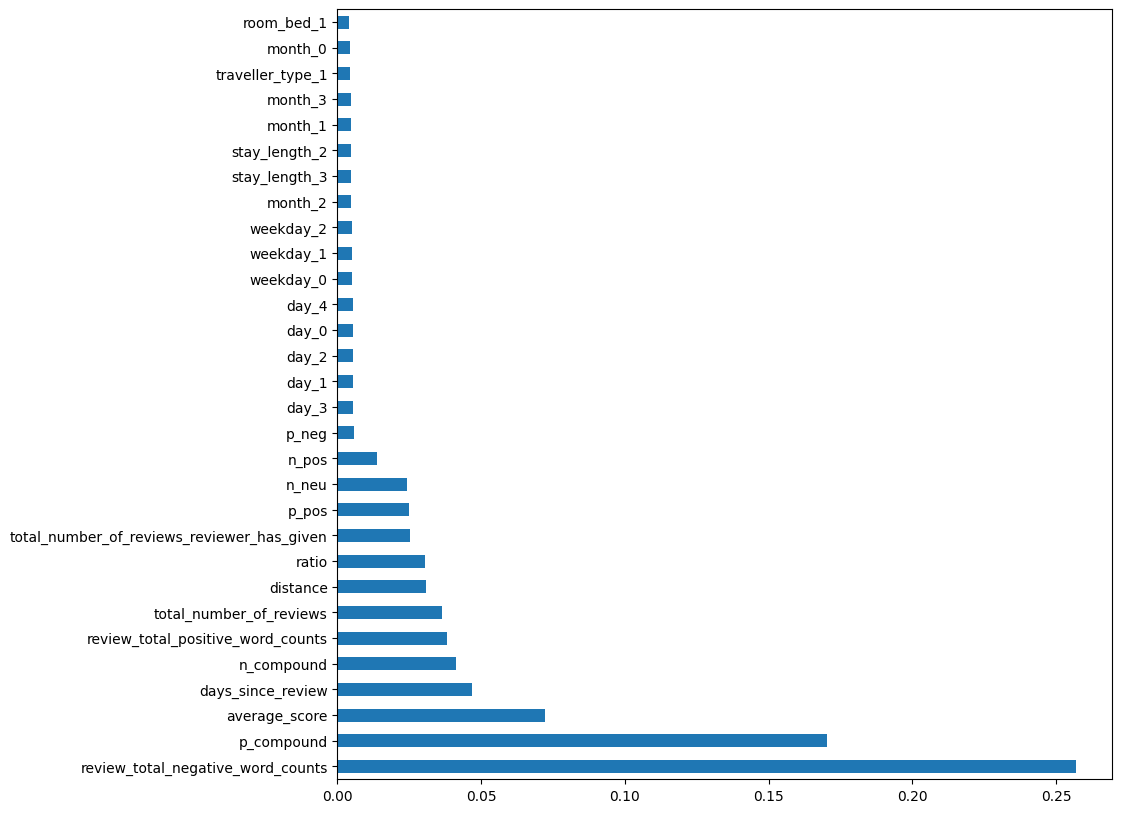

In [197]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')


In [198]:
# Удаляем "лишний" признак у тестовой выборки (которая "настоящая")

test_data = test_data.drop(['reviewer_score'], axis=1)


In [199]:
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке(которая "настоящая")
# Предсказанные значения записываем в переменную predict_submission

predict_submission = model.predict(test_data)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


In [200]:
# Округляем результат до сотых долей

for i in range(len(predict_submission)):
    predict_submission[i] = round(predict_submission[i], 2)

predict_submission


array([9.04, 7.43, 8.96, ..., 7.98, 9.61, 7.58])

In [201]:
# Сохраняем результат в файл сабмишна

sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()


,reviewer_score,id
0,9.04,488440
1,7.43,274649
2,8.96,374688
3,9.62,404352
4,9.47,451596


In [202]:
# Краткая статистика

sample_submission.describe()


,reviewer_score,id
count,128935.000000,128935.000000
mean,8.349429,258065.135533
std,1.149945,148917.547662
min,3.110000,2.000000
25%,7.700000,129124.000000
50%,8.630000,257459.000000
75%,9.260000,387599.000000
max,9.980000,515737.000000


[**Содержание**](#100)

# 8. Заключение / Conclusion <a class="anchor" id="8"></a>

1. Наибольшее влияние на результат (точность предсказания) оказали признаки, генерированные из текстов положительных и отрицательных отзывов, а так же количество слов в этих отзывах.
2. Наличие  /отсутствие коллинеарных признаков не оказывает существенного влияния на точность.
3. Преобразование признаков (масштабирование) не оказывает влияния на точность.
4. Наибольшее влияние на результат (точность предсказания) оказывают признаки, для которых имеет значение каждая запись датасета. И это значение реально существующее, не искусственное  (например, значение Unknown, присваиваемое вместо пропуска - реально не существующее).